In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from datetime import datetime

In [16]:
df = pd.read_csv('cleaned_data.csv')
df = df[['DATE', 'INF_A', 'INF_B']]
df.head()

DATE  INF_A  INF_B
0  1996-12-29    0.0    0.0
1  1997-02-23    0.0    0.0
2  1997-03-02    0.0    0.0
3  1997-03-09    0.0    0.0
4  1997-03-16    0.0    0.0

In [17]:
# ---- Helper Functions ----
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return rmse, mae, mape

###  AR-Net Model

Epoch 20/80, Loss: 7312.011
Epoch 40/80, Loss: 5475.996
Epoch 60/80, Loss: 4206.688
Epoch 80/80, Loss: 3384.749

--- INF_A ---
Train RMSE: 57.86, MAE: 17.77, MAPE: 2384557760.40
Test  RMSE: 22.75, MAE: 13.84, MAPE: 34.46


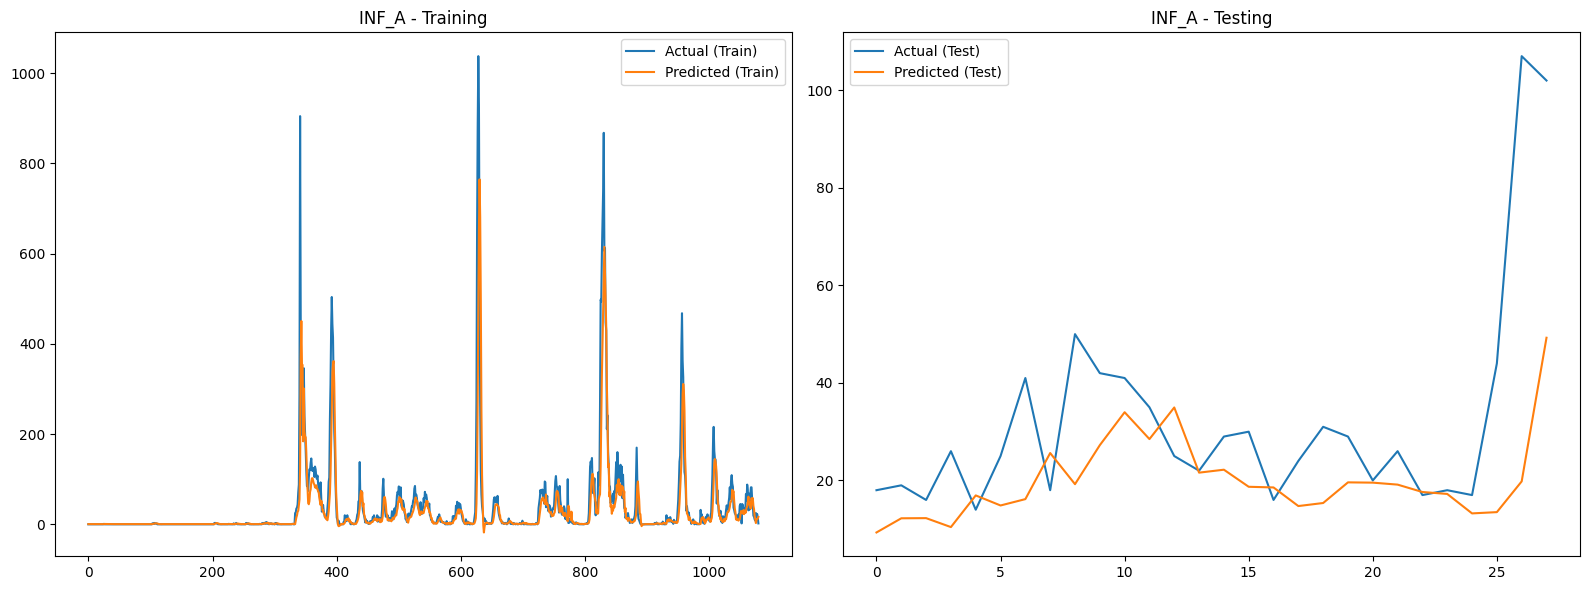

Epoch 20/80, Loss: 377.791
Epoch 40/80, Loss: 272.013
Epoch 60/80, Loss: 203.041
Epoch 80/80, Loss: 153.155

--- INF_B ---
Train RMSE: 12.30, MAE: 4.01, MAPE: 3884595129.79
Test  RMSE: 4.88, MAE: 3.43, MAPE: 57.55


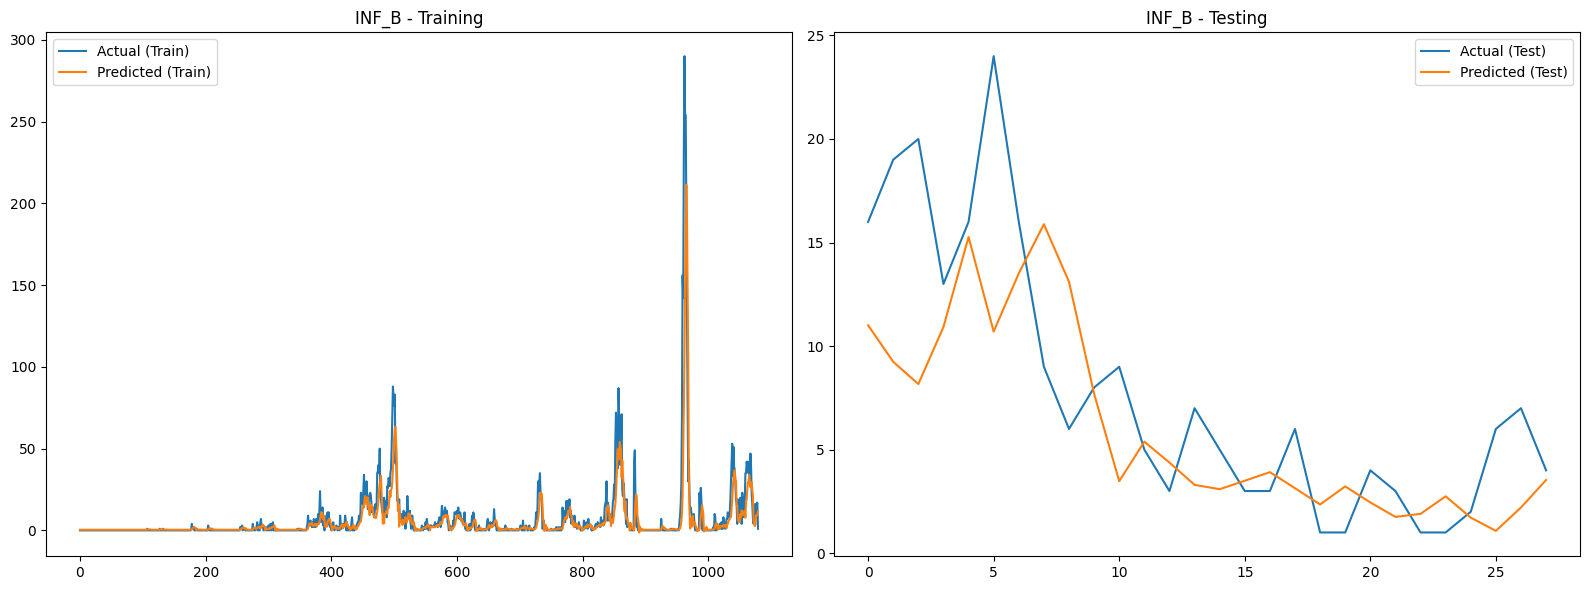

In [19]:
# ---- AR-NET Model ----
class ARNet(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
# ---- Main Function ----
def run_ar_net_forecast(target_col, seq_length=8, hidden_size=32, epochs=80, lr=0.001):
    # 1. Load Data
    df = pd.read_csv('cleaned_data.csv', parse_dates=['DATE'])
    df = df.sort_values('DATE')
    df = df[['DATE', target_col]].dropna()
    df[target_col] = df[target_col].astype(float)

    # 2. Train/Test Split
    train_df = df[df['DATE'] < '2024-01-01']
    test_df = df[df['DATE'] >= '2024-01-01']
    train_vals = train_df[target_col].values
    test_vals = test_df[target_col].values

    # 3. Sequence Creation
    X_train, y_train = create_sequences(train_vals, seq_length)
    X_test, y_test = create_sequences(np.concatenate([train_vals[-seq_length:], test_vals]), seq_length)

    # 4. Torch Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # 5. Model Init
    model = ARNet(seq_length, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 6. Training Loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.3f}')

    # 7. Predictions
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_t).numpy().flatten()
        test_pred = model(X_test_t).numpy().flatten()

    # 8. Evaluation
    train_rmse, train_mae, train_mape = evaluate(y_train, train_pred)
    test_rmse, test_mae, test_mape = evaluate(y_test, test_pred)

    print(f"\n--- {target_col} ---")
    print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}")
    print(f"Test  RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}")

    # 9. Plotting
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(y_train, label='Actual (Train)')
    plt.plot(train_pred, label='Predicted (Train)')
    plt.title(f'{target_col} - Training')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(y_test, label='Actual (Test)')
    plt.plot(test_pred, label='Predicted (Test)')
    plt.title(f'{target_col} - Testing')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'train': {'rmse': train_rmse, 'mae': train_mae, 'mape': train_mape},
        'test': {'rmse': test_rmse, 'mae': test_mae, 'mape': test_mape}
    }

# ---- Run for Both Targets ----
metrics_a = run_ar_net_forecast('INF_A')
metrics_b = run_ar_net_forecast('INF_B')


### Hyper Parameter Tunning

Epoch 20/120, Loss: 8226.161
Epoch 40/120, Loss: 6591.304
Epoch 60/120, Loss: 5454.656
Epoch 80/120, Loss: 4732.733
Epoch 100/120, Loss: 4198.627
Epoch 120/120, Loss: 3777.076

--- INF_A ---
Train RMSE: 61.31, MAE: 19.23, MAPE: 3022757746.74
Test  RMSE: 23.15, MAE: 13.80, MAPE: 33.28


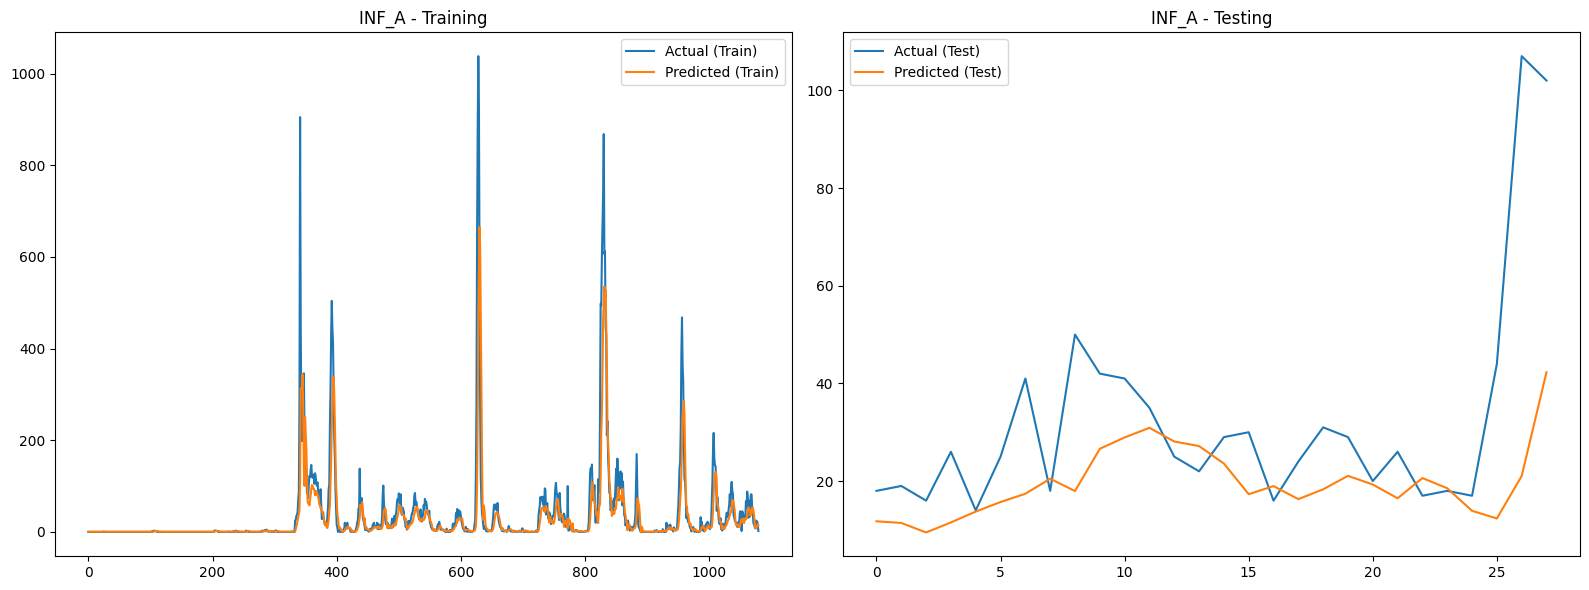

Epoch 20/50, Loss: 1977.572
Epoch 40/50, Loss: 1542.432

--- INF_A ---
Train RMSE: 38.44, MAE: 12.86, MAPE: 4509467994.27
Test  RMSE: 17.07, MAE: 11.79, MAPE: 38.50


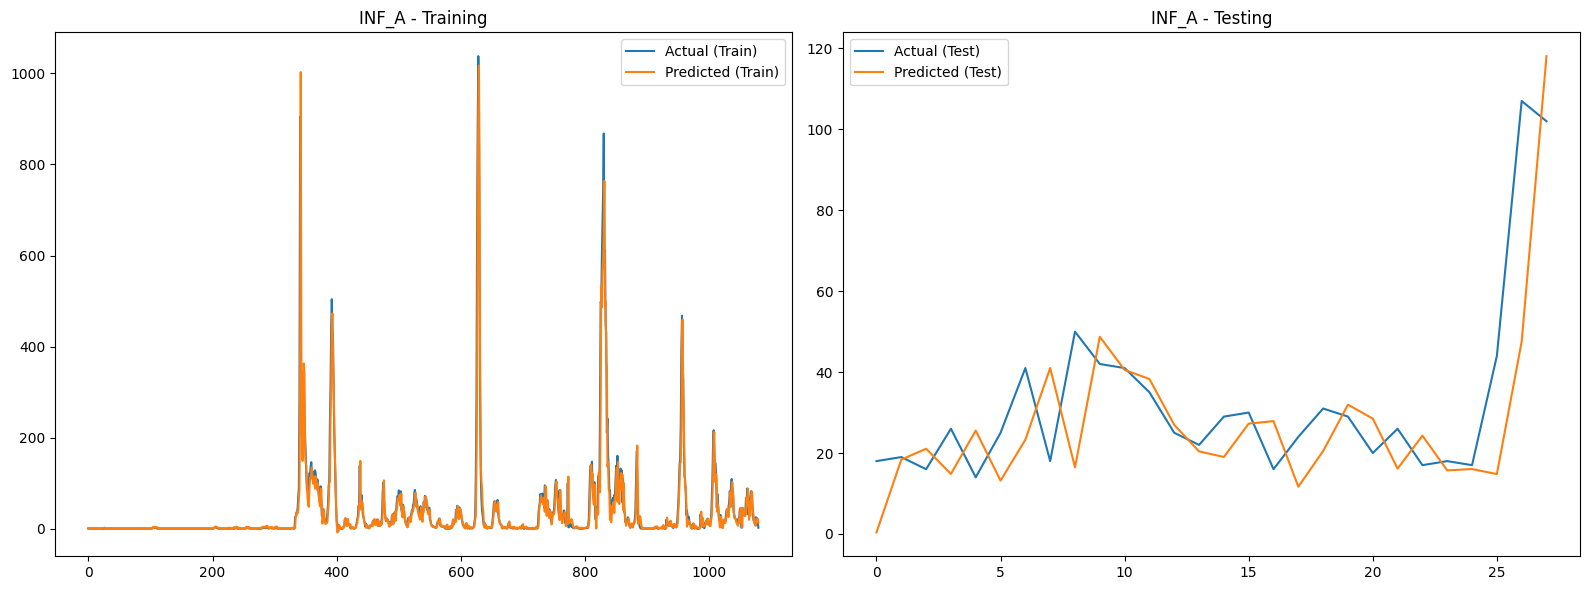

Epoch 20/80, Loss: 1804.968
Epoch 40/80, Loss: 1474.417
Epoch 60/80, Loss: 1385.948
Epoch 80/80, Loss: 1346.235

--- INF_A ---
Train RMSE: 36.67, MAE: 12.55, MAPE: 7508836331.10
Test  RMSE: 17.05, MAE: 11.65, MAPE: 37.73


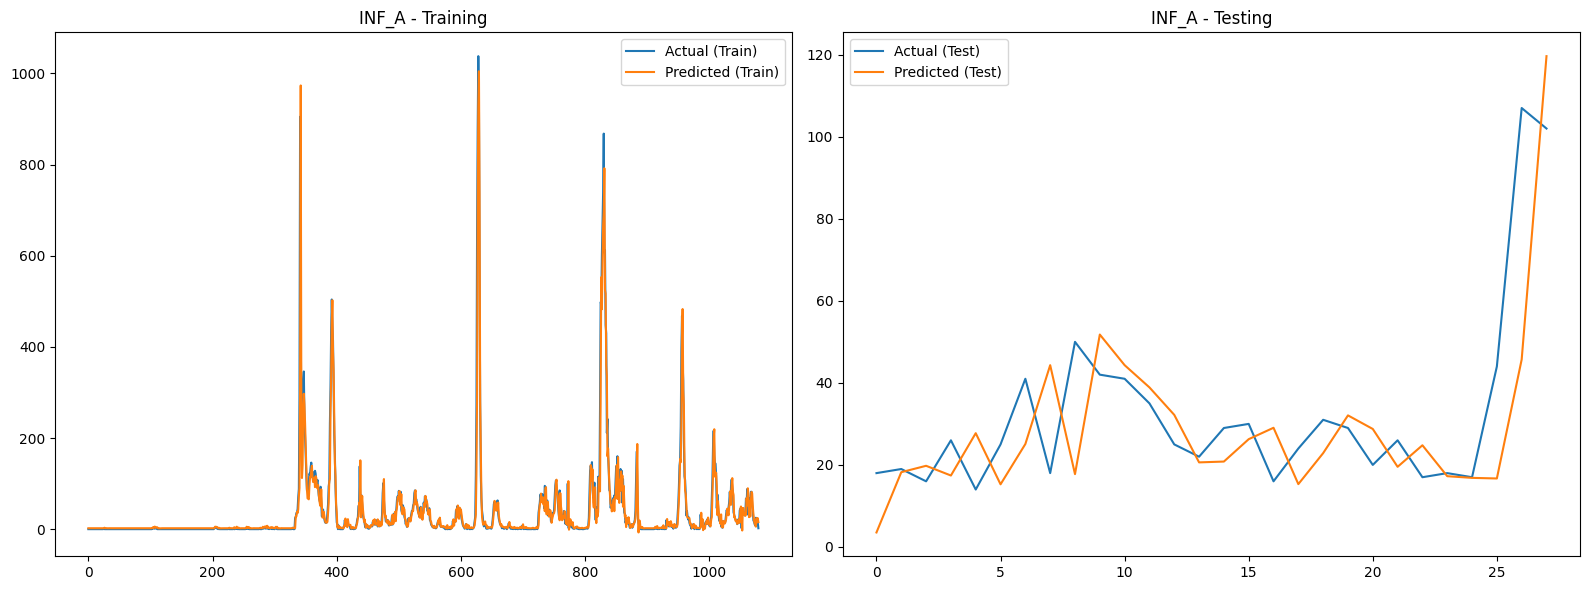

Epoch 20/80, Loss: 4477.713
Epoch 40/80, Loss: 2850.573
Epoch 60/80, Loss: 2223.515
Epoch 80/80, Loss: 1852.108

--- INF_A ---
Train RMSE: 42.87, MAE: 13.74, MAPE: 2942045912.49
Test  RMSE: 19.07, MAE: 12.47, MAPE: 37.06


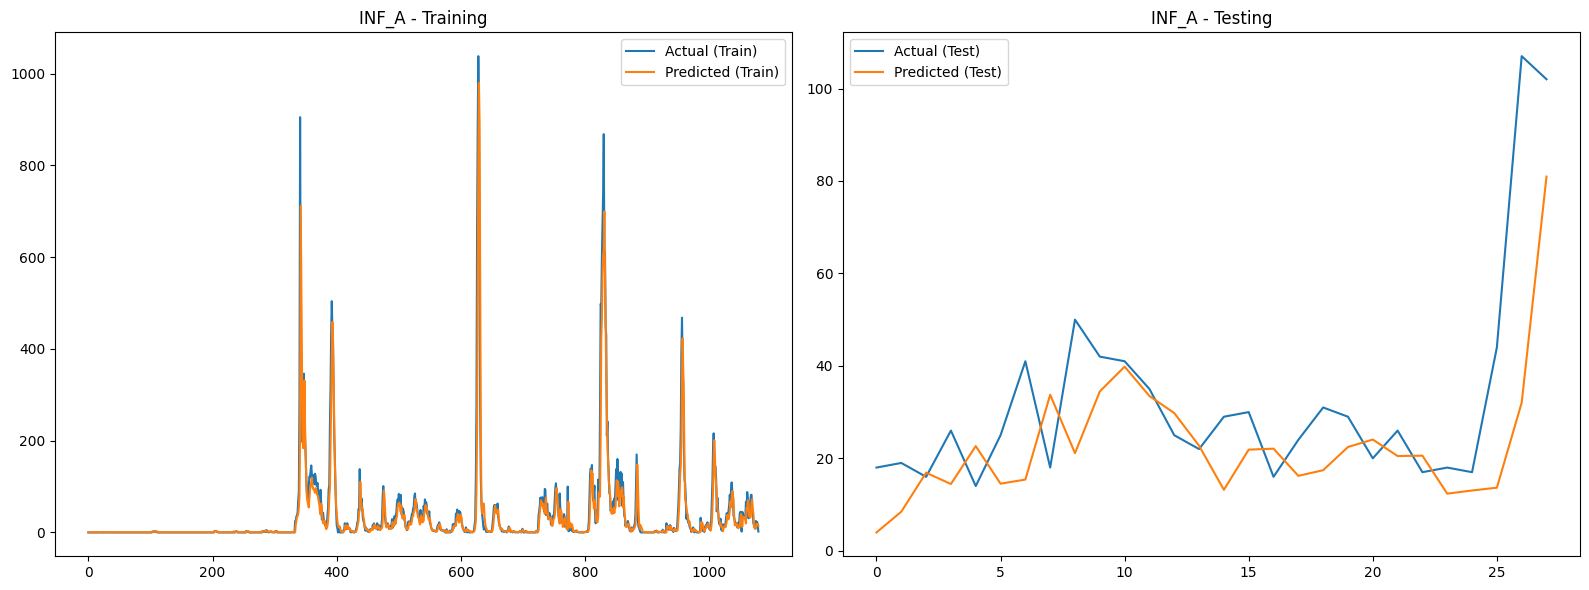

Epoch 20/80, Loss: 4715.739
Epoch 40/80, Loss: 2883.331
Epoch 60/80, Loss: 2175.594
Epoch 80/80, Loss: 1823.784

--- INF_A ---
Train RMSE: 42.55, MAE: 13.79, MAPE: 2593471566.20
Test  RMSE: 19.02, MAE: 12.38, MAPE: 36.89


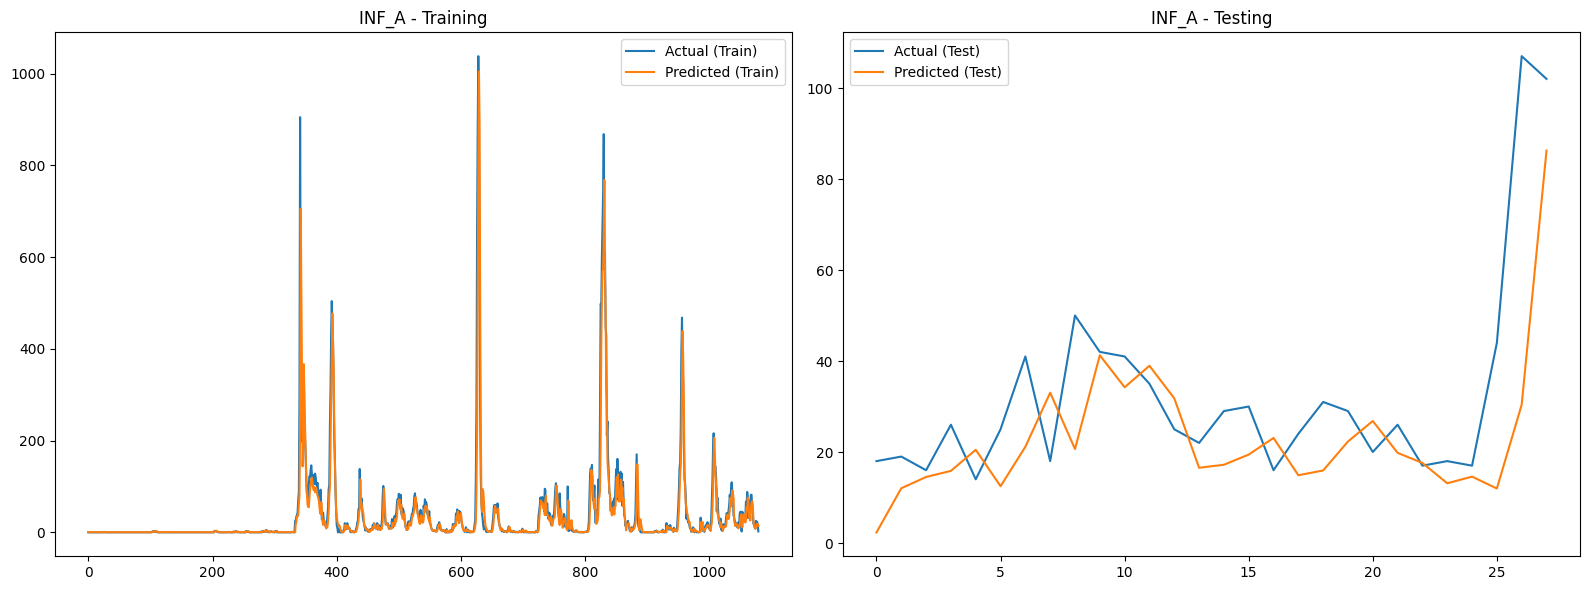

Epoch 20/80, Loss: 5339.817
Epoch 40/80, Loss: 3983.972
Epoch 60/80, Loss: 3098.350
Epoch 80/80, Loss: 2438.231

--- INF_A ---
Train RMSE: 49.10, MAE: 15.61, MAPE: 2095952205.00
Test  RMSE: 19.53, MAE: 12.11, MAPE: 32.66


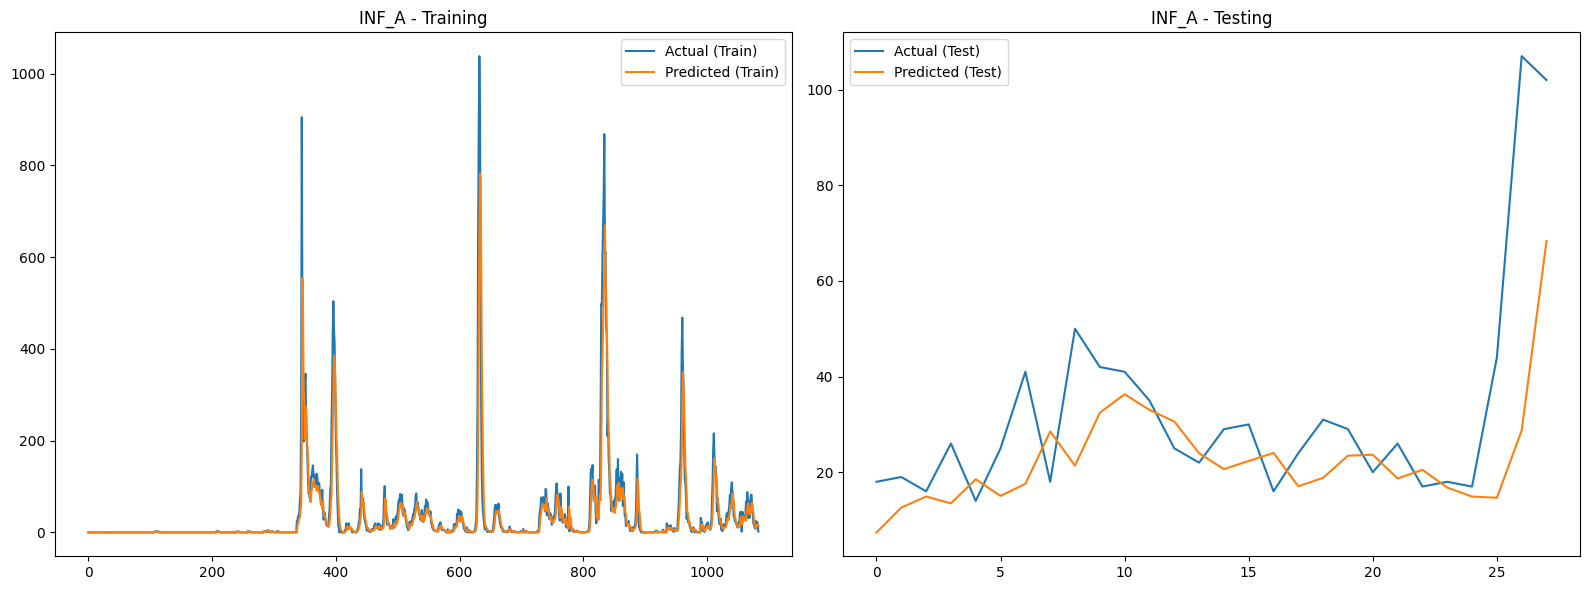

Epoch 20/120, Loss: 3308.068
Epoch 40/120, Loss: 2463.045
Epoch 60/120, Loss: 1858.078
Epoch 80/120, Loss: 1598.222
Epoch 100/120, Loss: 1492.211
Epoch 120/120, Loss: 1455.768

--- INF_A ---
Train RMSE: 38.14, MAE: 12.41, MAPE: 1661727631.40
Test  RMSE: 17.68, MAE: 12.05, MAPE: 39.18


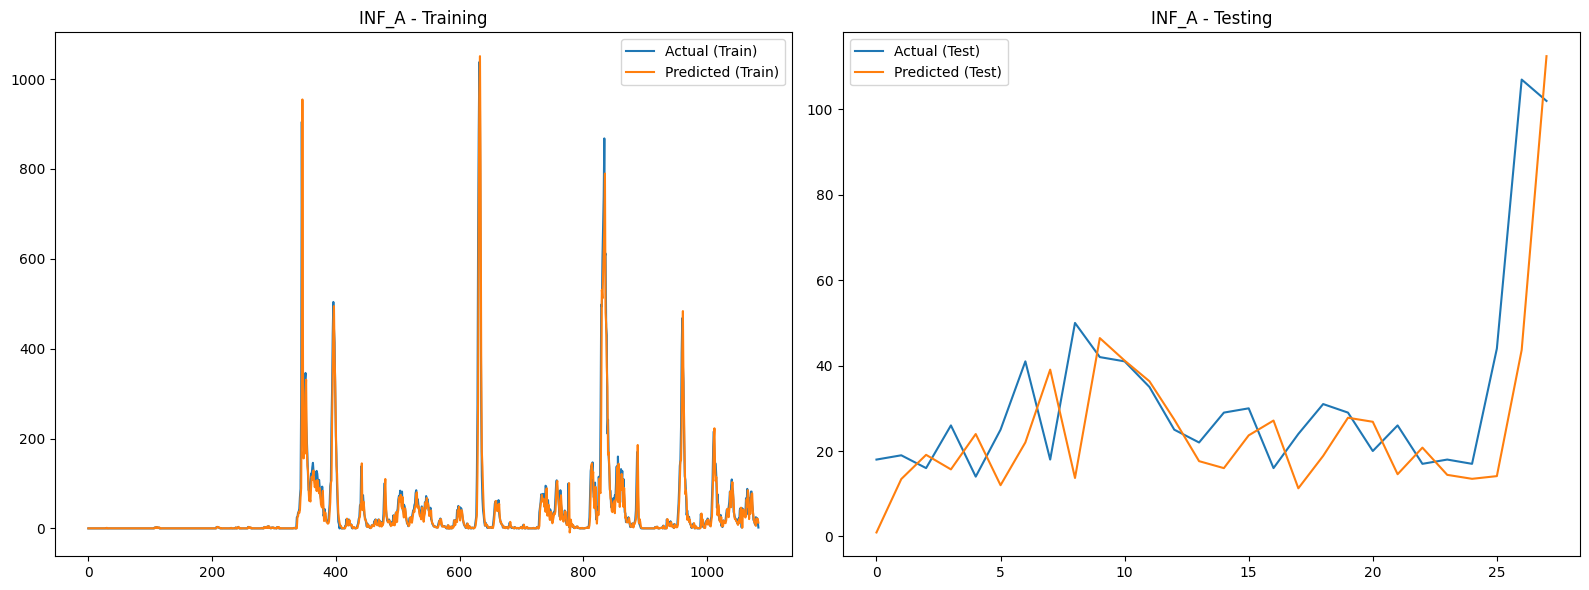

Epoch 20/50, Loss: 12681.554
Epoch 40/50, Loss: 8870.723

--- INF_A ---
Train RMSE: 85.79, MAE: 27.83, MAPE: 1296526869.13
Test  RMSE: 32.15, MAE: 24.28, MAPE: 70.15


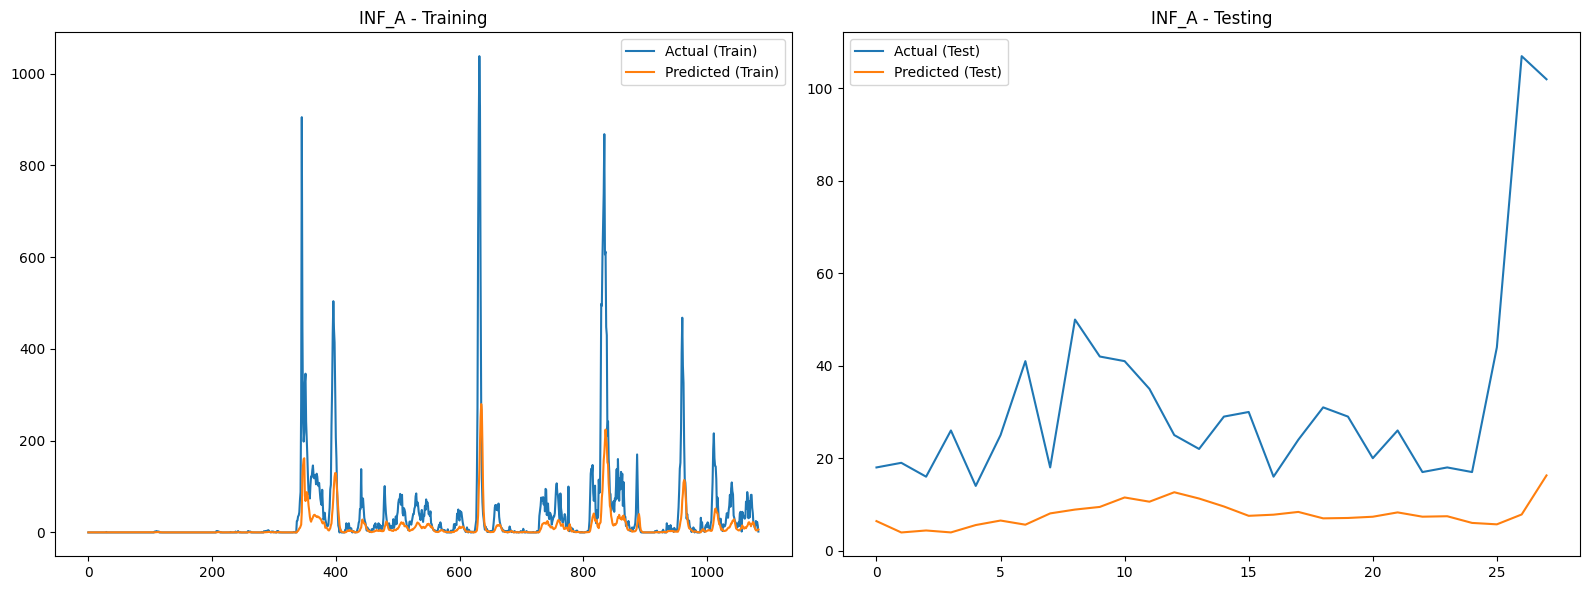

Epoch 20/50, Loss: 4085.769
Epoch 40/50, Loss: 3207.521

--- INF_A ---
Train RMSE: 53.91, MAE: 16.97, MAPE: 2249250486.65
Test  RMSE: 20.58, MAE: 12.55, MAPE: 33.29


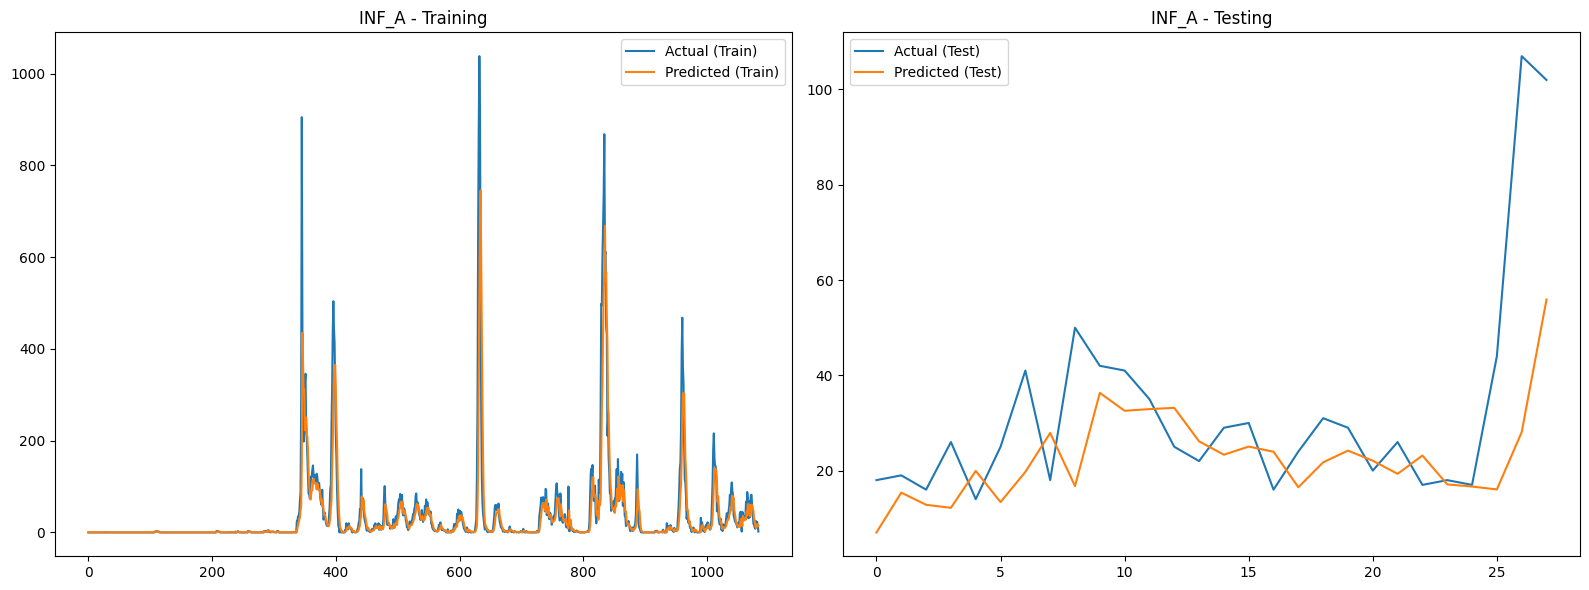

Epoch 20/50, Loss: 5935.010
Epoch 40/50, Loss: 4967.789

--- INF_A ---
Train RMSE: 67.55, MAE: 20.72, MAPE: 1465376307.23
Test  RMSE: 26.64, MAE: 17.27, MAPE: 44.27


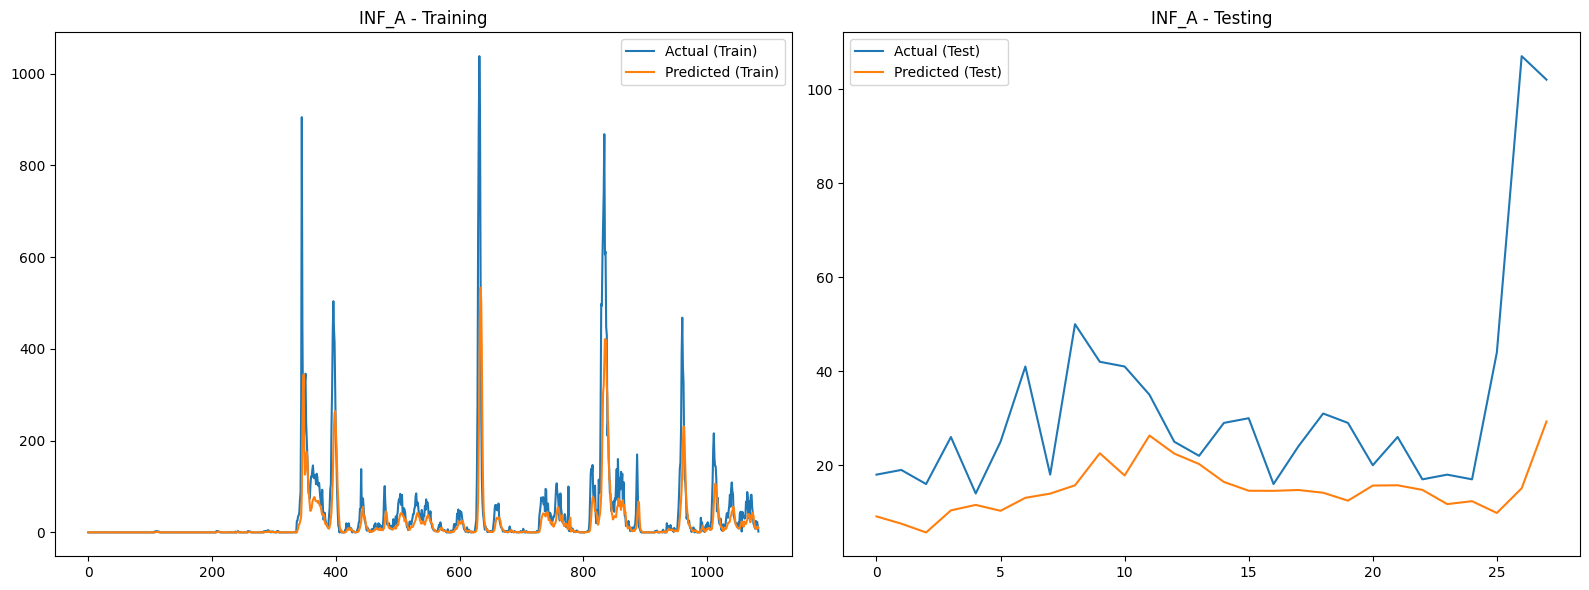

Epoch 20/120, Loss: 9652.434
Epoch 40/120, Loss: 7735.131
Epoch 60/120, Loss: 5892.546
Epoch 80/120, Loss: 4397.561
Epoch 100/120, Loss: 3529.689
Epoch 120/120, Loss: 3012.390

--- INF_A ---
Train RMSE: 54.70, MAE: 17.29, MAPE: 4369029778.56
Test  RMSE: 21.08, MAE: 12.33, MAPE: 30.74


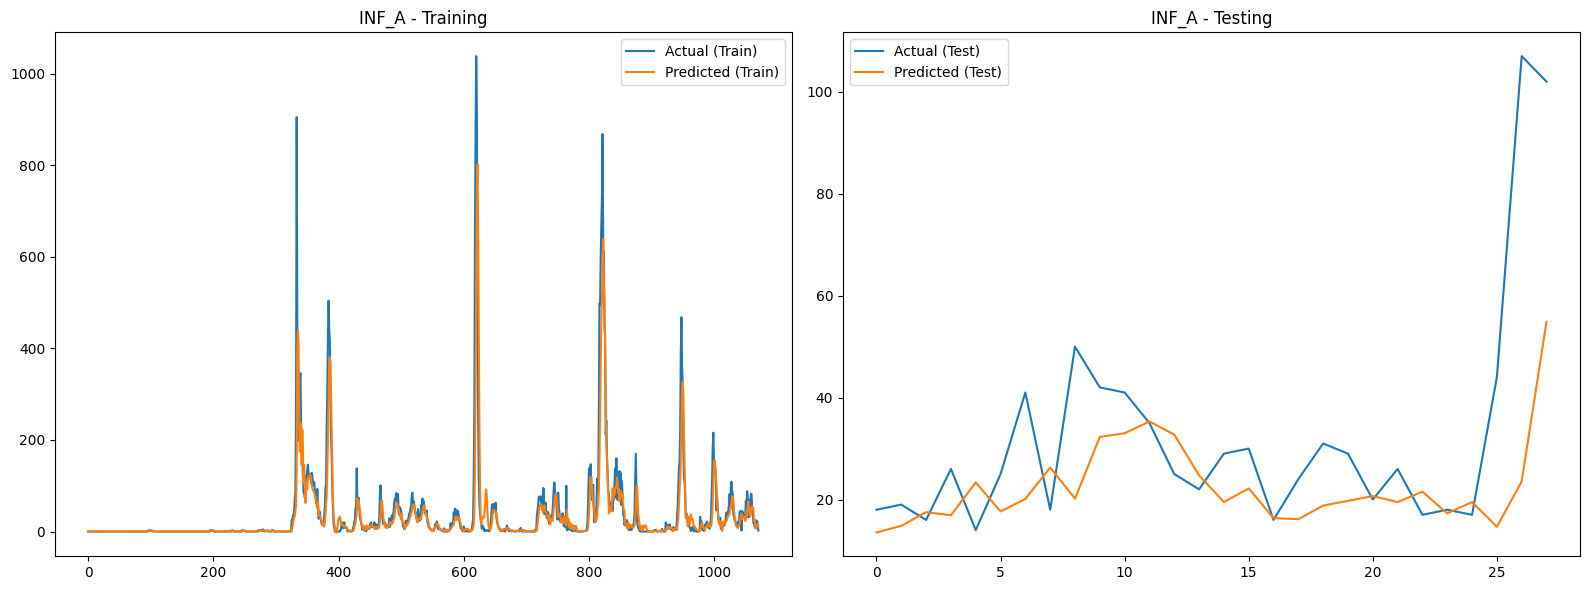

Epoch 20/50, Loss: 11774.185
Epoch 40/50, Loss: 10207.602

--- INF_A ---
Train RMSE: 97.30, MAE: 34.01, MAPE: 2520082716.40
Test  RMSE: 37.24, MAE: 29.68, MAPE: 90.19


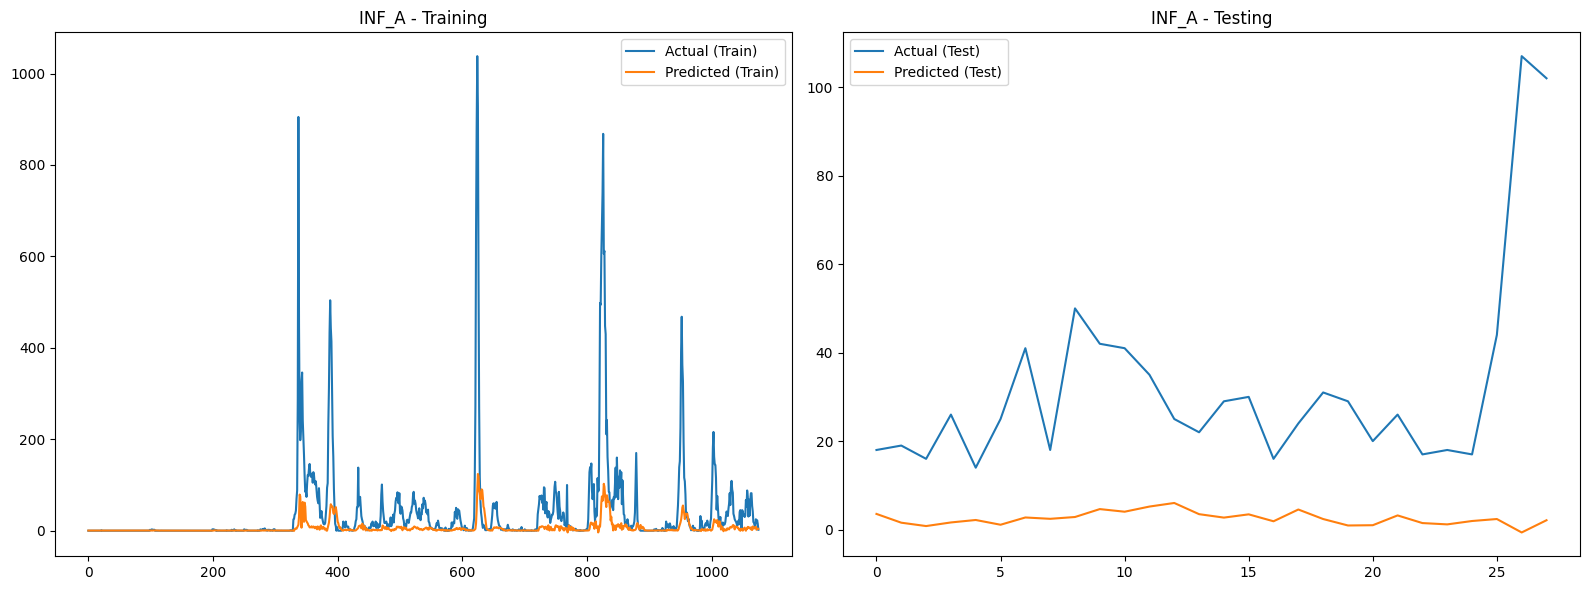

Epoch 20/120, Loss: 3477.715
Epoch 40/120, Loss: 2323.059
Epoch 60/120, Loss: 1872.776
Epoch 80/120, Loss: 1696.997
Epoch 100/120, Loss: 1597.568
Epoch 120/120, Loss: 1536.728

--- INF_A ---
Train RMSE: 39.17, MAE: 13.37, MAPE: 8303492894.18
Test  RMSE: 16.83, MAE: 11.14, MAPE: 36.55


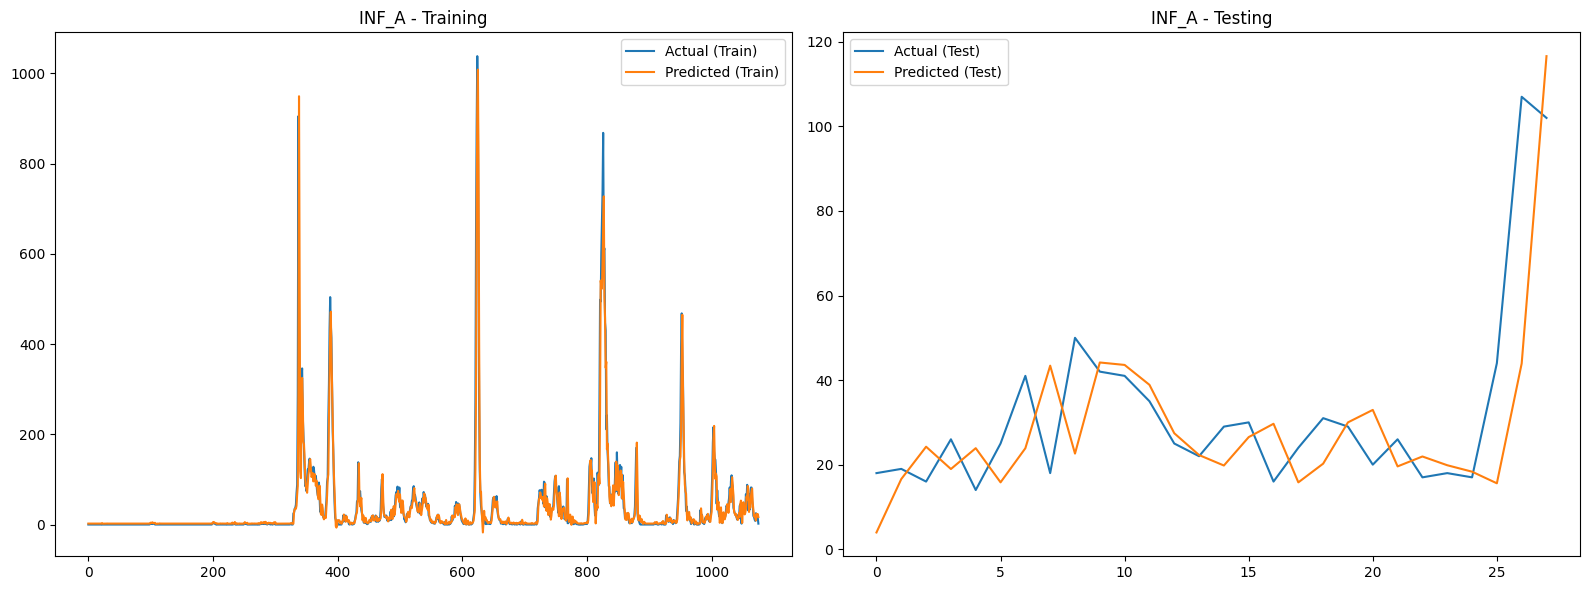

Epoch 20/120, Loss: 9230.914
Epoch 40/120, Loss: 7555.109
Epoch 60/120, Loss: 6542.237
Epoch 80/120, Loss: 5743.134
Epoch 100/120, Loss: 5095.749
Epoch 120/120, Loss: 4603.240

--- INF_A ---
Train RMSE: 67.69, MAE: 20.75, MAPE: 2253869642.32
Test  RMSE: 23.49, MAE: 13.66, MAPE: 32.58


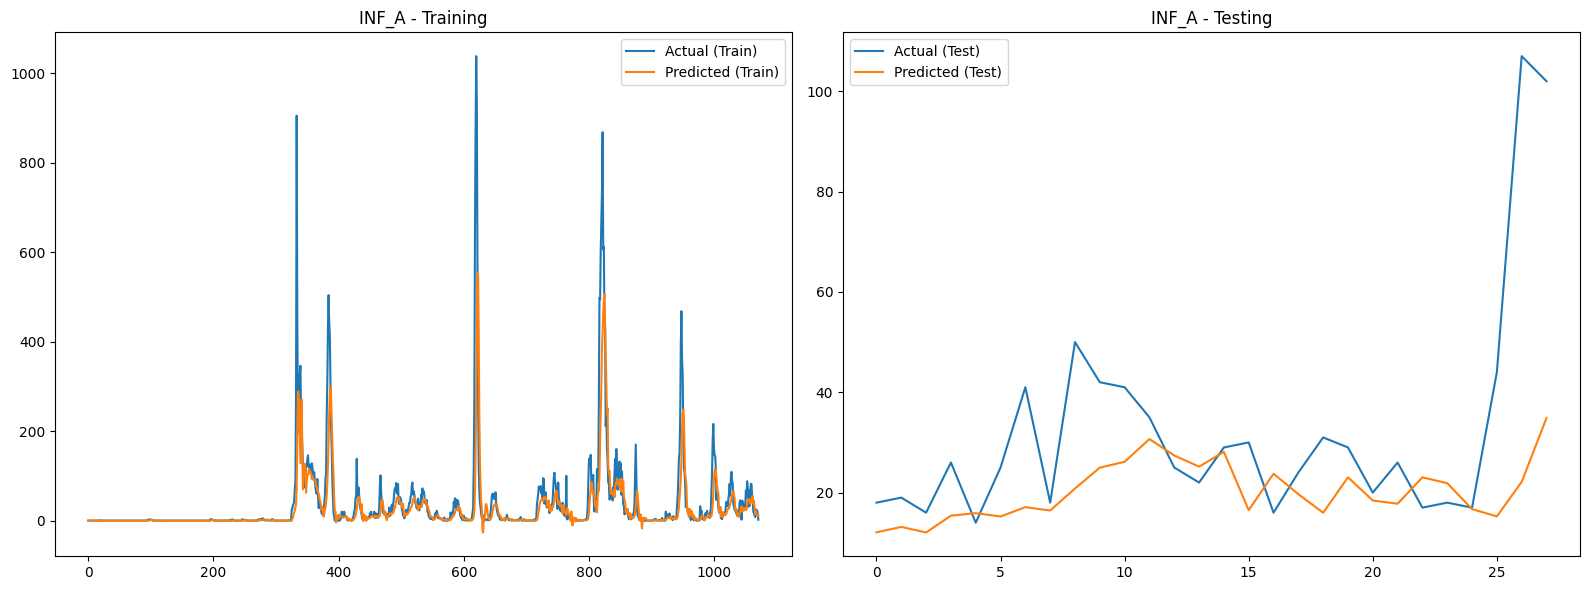

Epoch 20/120, Loss: 7454.899
Epoch 40/120, Loss: 5132.438
Epoch 60/120, Loss: 3821.894
Epoch 80/120, Loss: 2859.459
Epoch 100/120, Loss: 2331.233
Epoch 120/120, Loss: 2071.540

--- INF_A ---
Train RMSE: 45.40, MAE: 14.50, MAPE: 2746921749.03
Test  RMSE: 19.26, MAE: 12.48, MAPE: 36.72


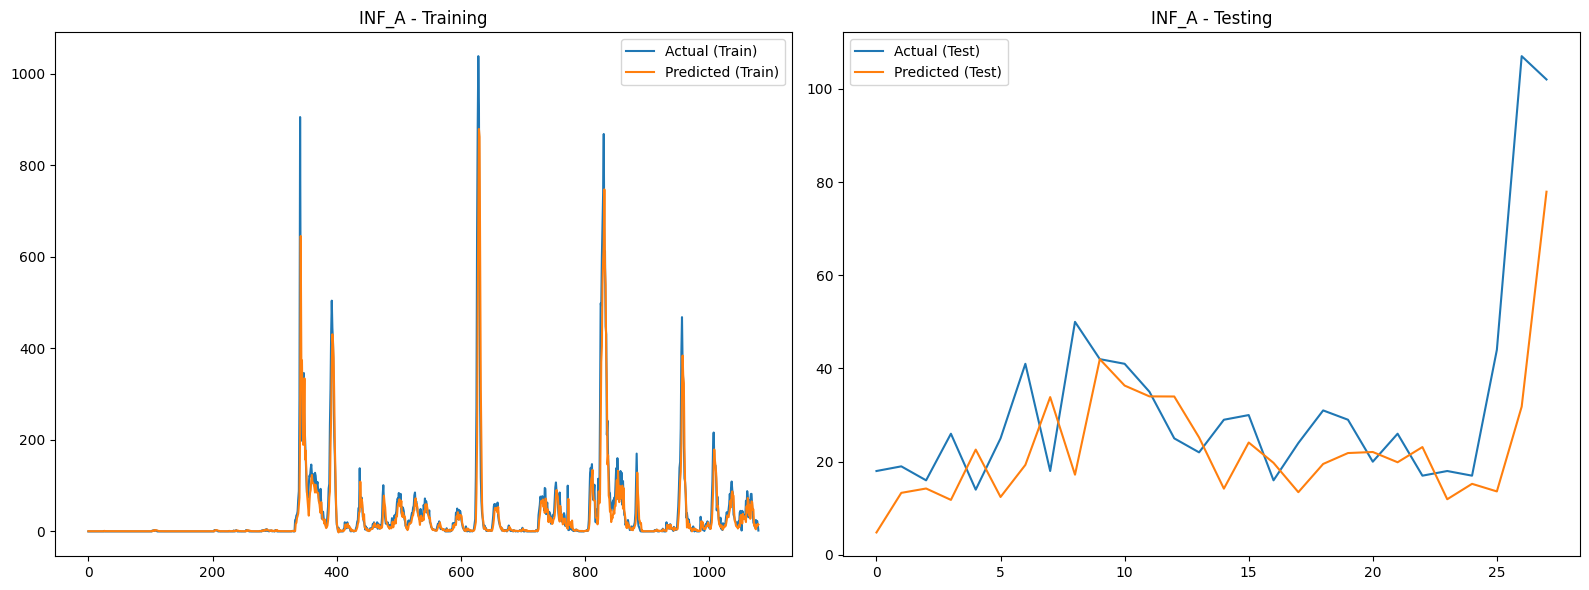

Epoch 20/50, Loss: 9104.793
Epoch 40/50, Loss: 7747.429

--- INF_A ---
Train RMSE: 84.35, MAE: 27.65, MAPE: 5242254119.96
Test  RMSE: 28.64, MAE: 18.64, MAPE: 45.95


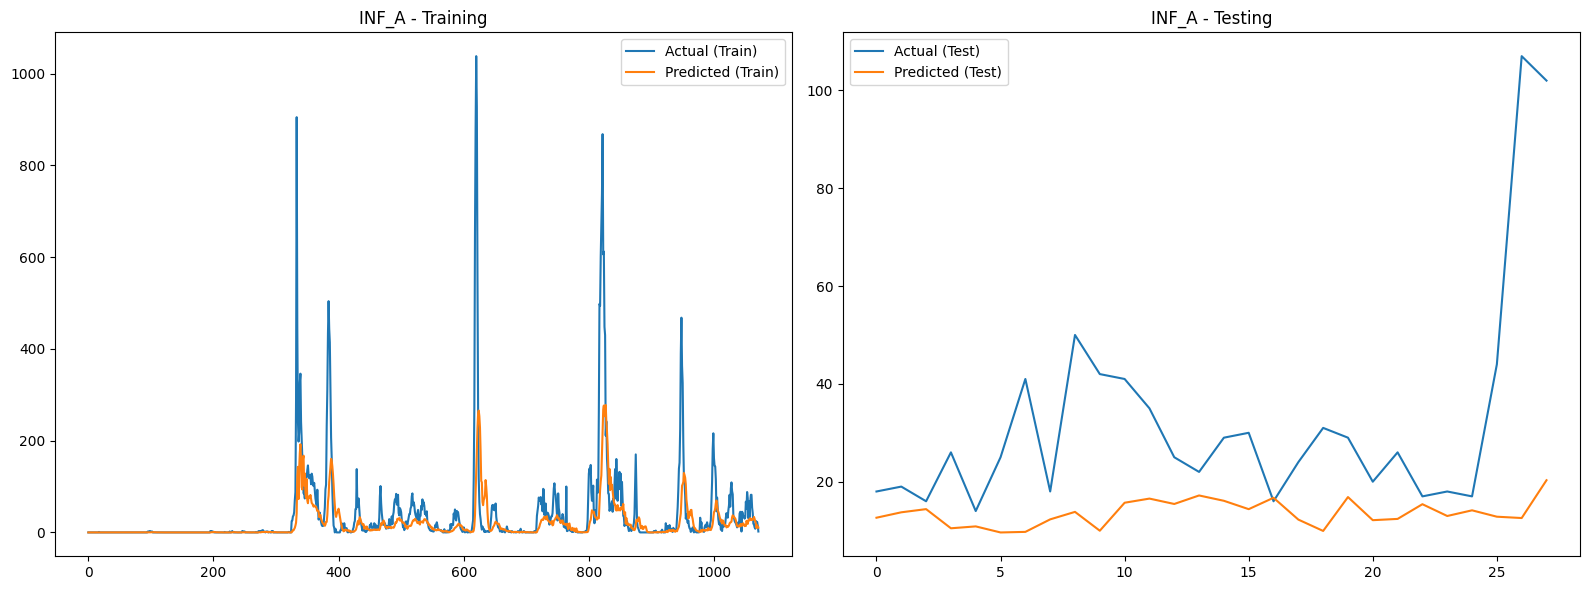

Epoch 20/80, Loss: 2325.404
Epoch 40/80, Loss: 1649.639
Epoch 60/80, Loss: 1457.824
Epoch 80/80, Loss: 1409.202

--- INF_A ---
Train RMSE: 37.51, MAE: 12.43, MAPE: 5288649188.86
Test  RMSE: 17.33, MAE: 12.00, MAPE: 38.53


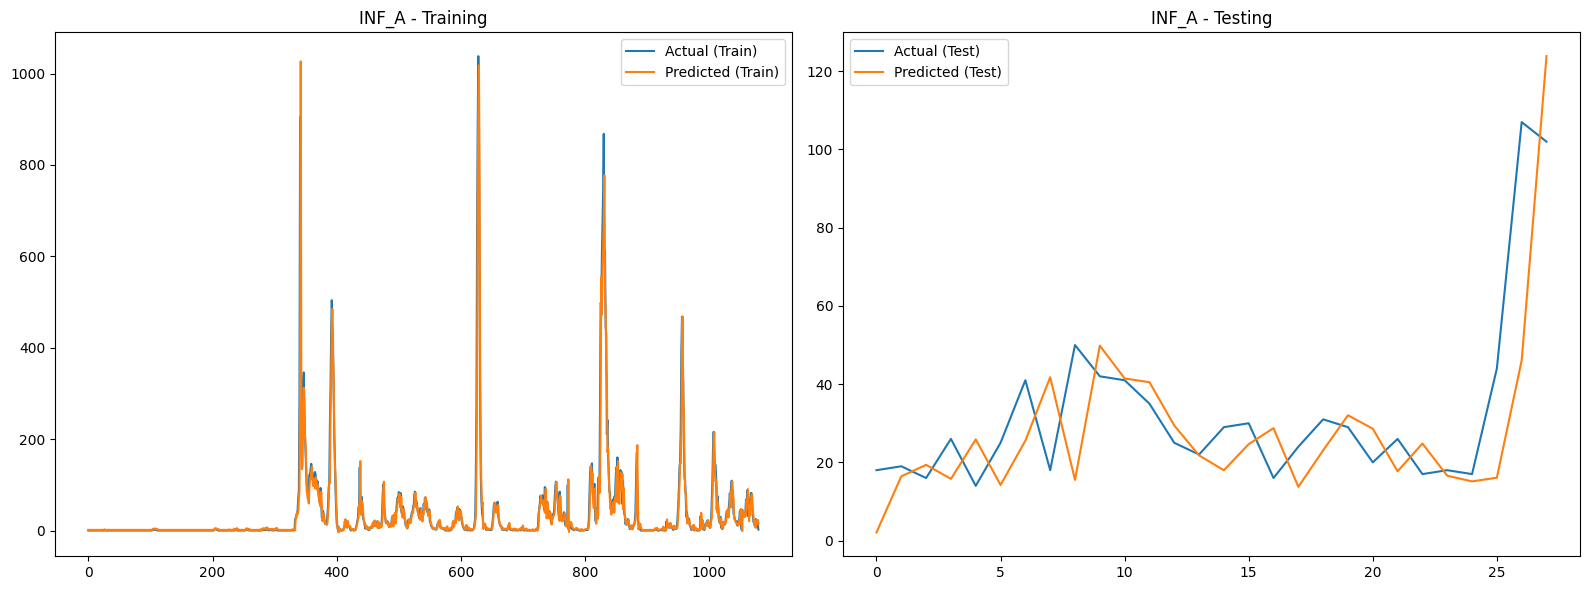

Epoch 20/120, Loss: 9406.992
Epoch 40/120, Loss: 7605.842
Epoch 60/120, Loss: 6155.968
Epoch 80/120, Loss: 4902.082
Epoch 100/120, Loss: 3945.219
Epoch 120/120, Loss: 3265.217

--- INF_A ---
Train RMSE: 56.90, MAE: 17.48, MAPE: 2588811435.34
Test  RMSE: 19.77, MAE: 12.37, MAPE: 33.69


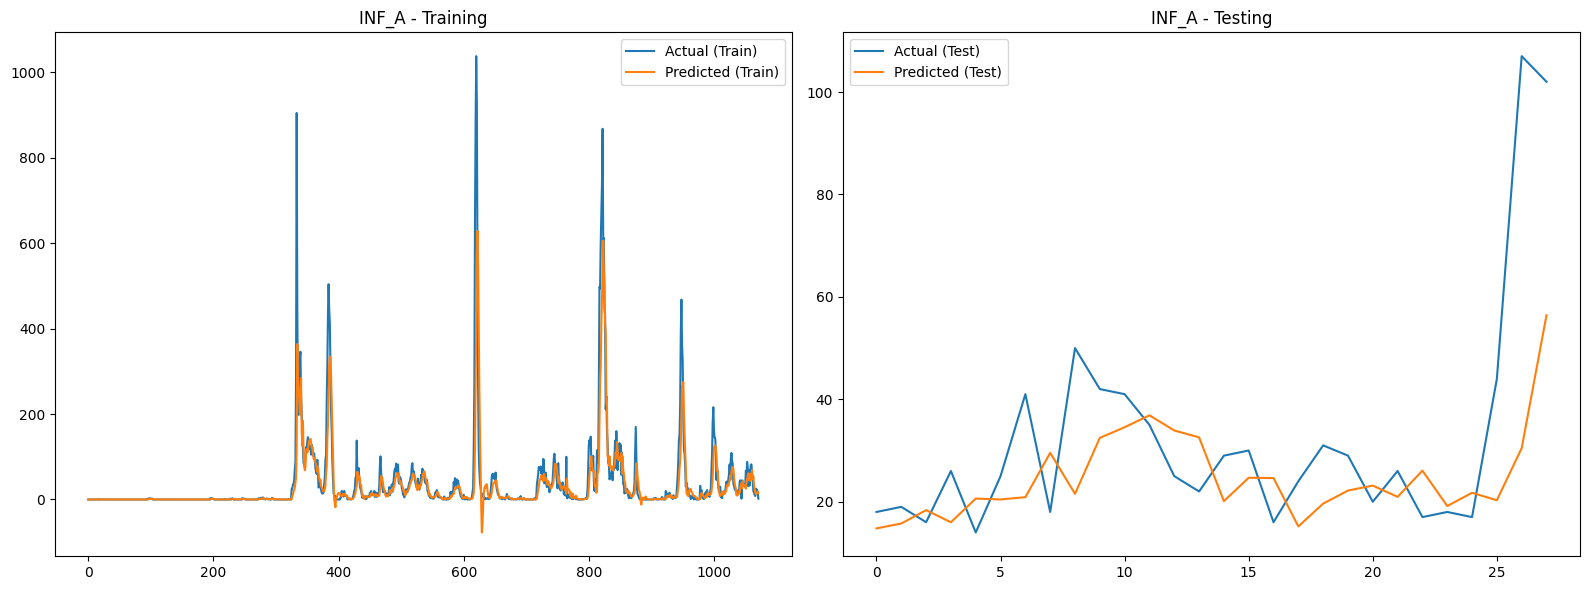

Epoch 20/80, Loss: 3243.888
Epoch 40/80, Loss: 2060.038
Epoch 60/80, Loss: 1699.610
Epoch 80/80, Loss: 1504.833

--- INF_A ---
Train RMSE: 38.72, MAE: 13.11, MAPE: 6492054983.07
Test  RMSE: 17.05, MAE: 11.25, MAPE: 36.83


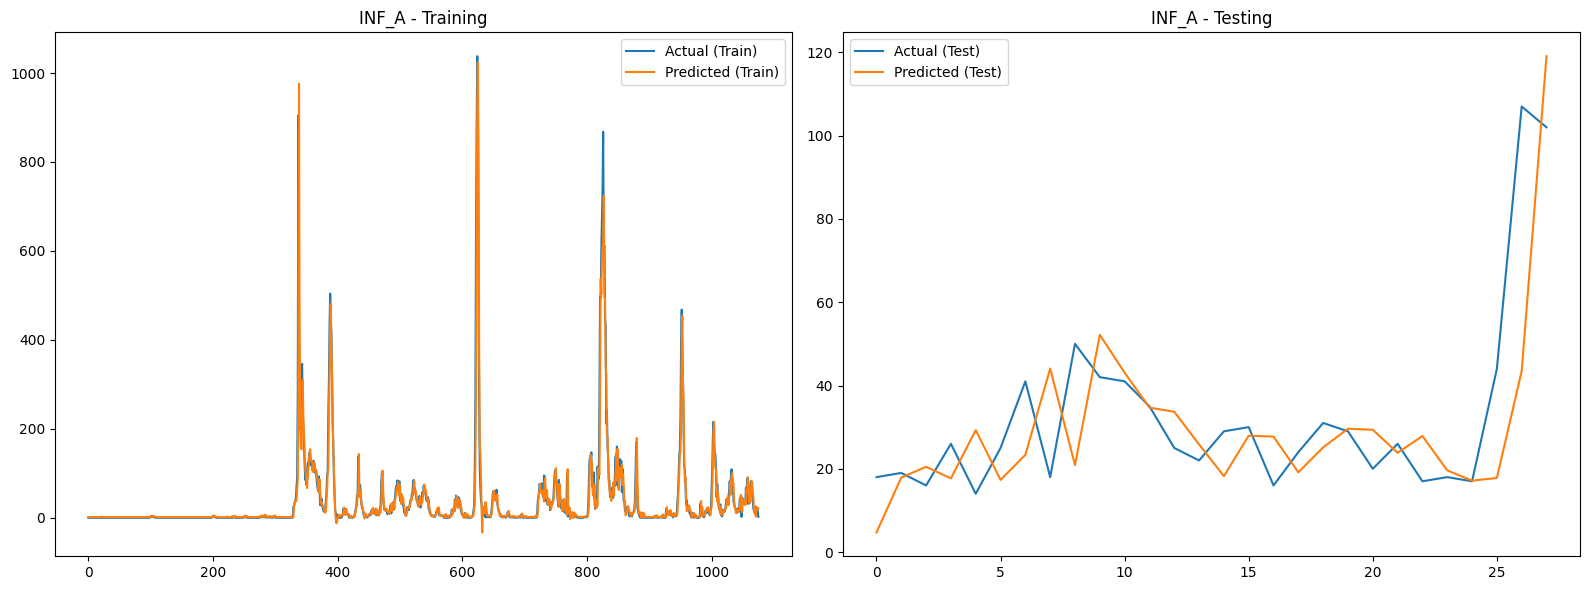

Epoch 20/80, Loss: 3317.604
Epoch 40/80, Loss: 2132.728
Epoch 60/80, Loss: 1678.368
Epoch 80/80, Loss: 1530.015

--- INF_A ---
Train RMSE: 39.06, MAE: 13.15, MAPE: 7648483963.65
Test  RMSE: 16.98, MAE: 11.21, MAPE: 34.83


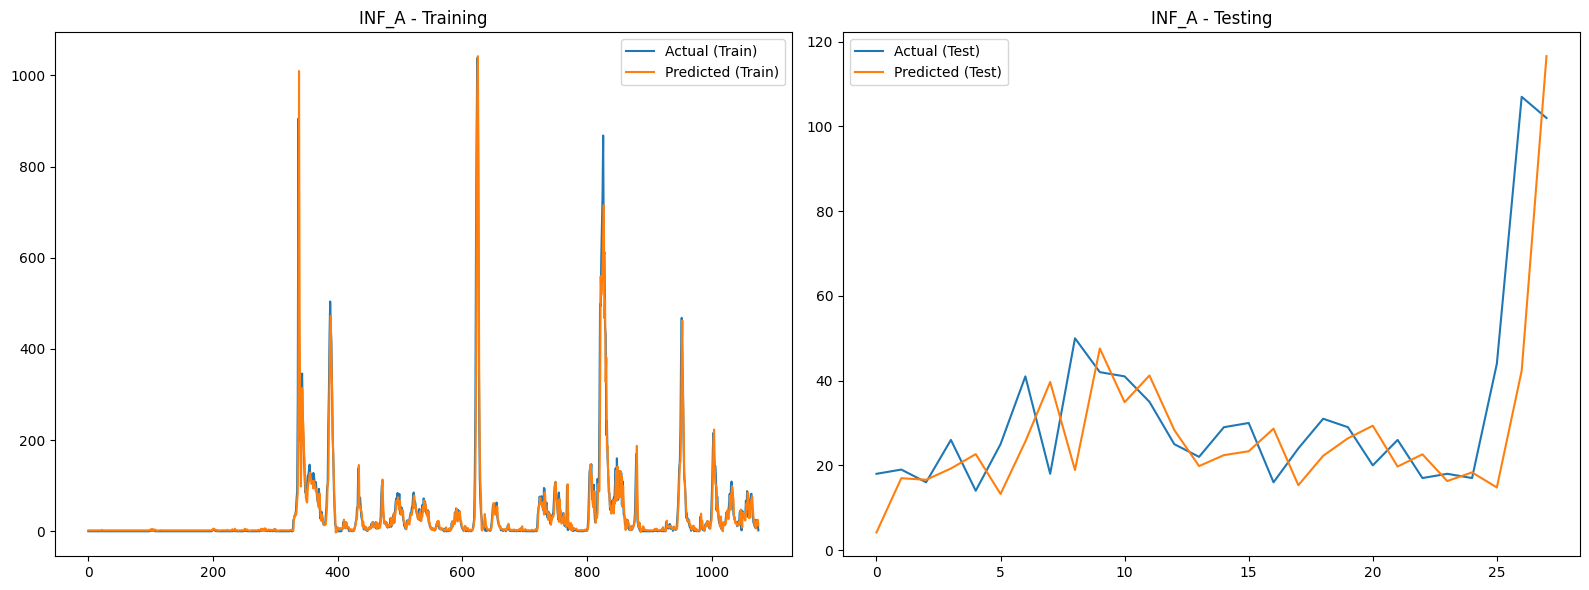

Best hyperparameters found: {'seq_length': 12, 'hidden_size': 16, 'lr': 0.01, 'epochs': 120}
Best test RMSE: 16.82696662033511


In [22]:
import random

# Define search space
seq_lengths = [4, 8, 12, 16]
hidden_sizes = [16, 32, 64, 128]
learning_rates = [0.01, 0.001, 0.0005]
epochs_list = [50, 80, 120]

best_score = float('inf')
best_params = None

for i in range(20):  # Try 20 random combinations
    params = {
        'seq_length': random.choice(seq_lengths),
        'hidden_size': random.choice(hidden_sizes),
        'lr': random.choice(learning_rates),
        'epochs': random.choice(epochs_list)
    }
    # Train and evaluate your AR-NET model here using these params
    # For demonstration, assume run_ar_net_forecast returns test RMSE
    metrics = run_ar_net_forecast('INF_A', **params)
    score = metrics['test']['rmse']
    if score < best_score:
        best_score = score
        best_params = params

print("Best hyperparameters found:", best_params)
print("Best test RMSE:", best_score)


## For INF_B

Epoch 20/50, Loss: 76.012
Epoch 40/50, Loss: 51.939

--- INF_B ---
Train RMSE: 6.98, MAE: 3.19, MAPE: 4642514547.64
Test  RMSE: 4.46, MAE: 3.16, MAPE: 53.78


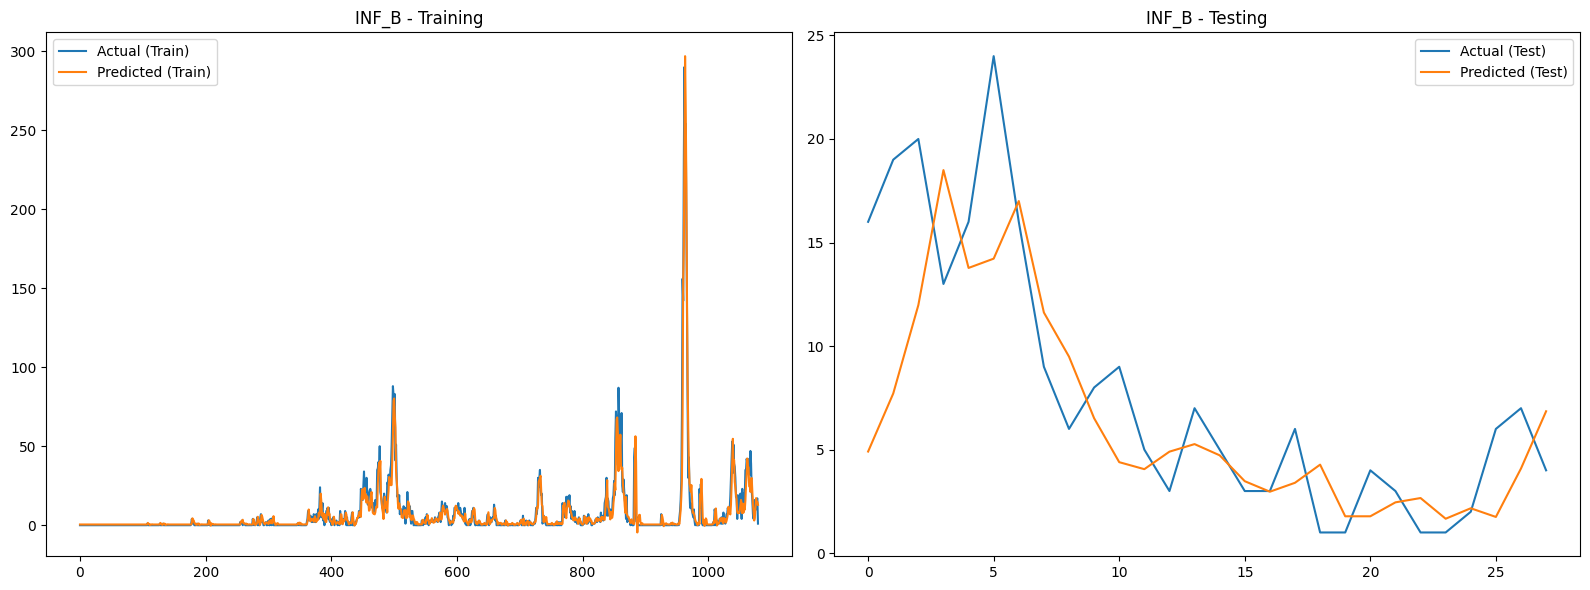

Epoch 20/80, Loss: 371.275
Epoch 40/80, Loss: 282.829
Epoch 60/80, Loss: 223.344
Epoch 80/80, Loss: 182.783

--- INF_B ---
Train RMSE: 13.46, MAE: 4.28, MAPE: 2359916610.92
Test  RMSE: 5.02, MAE: 3.41, MAPE: 46.21


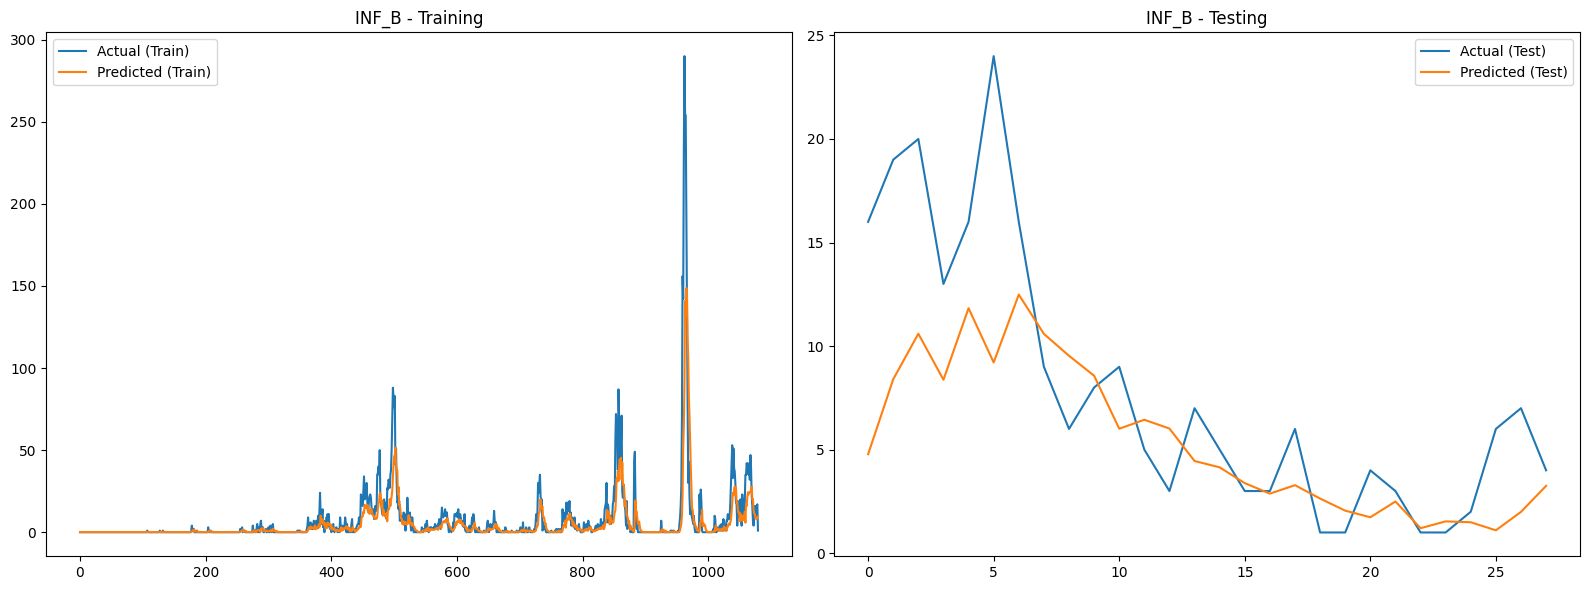

Epoch 20/120, Loss: 724.672
Epoch 40/120, Loss: 580.428
Epoch 60/120, Loss: 477.995
Epoch 80/120, Loss: 399.523
Epoch 100/120, Loss: 338.873
Epoch 120/120, Loss: 290.177

--- INF_B ---
Train RMSE: 16.97, MAE: 5.17, MAPE: 3939900666.06
Test  RMSE: 4.64, MAE: 3.40, MAPE: 64.37


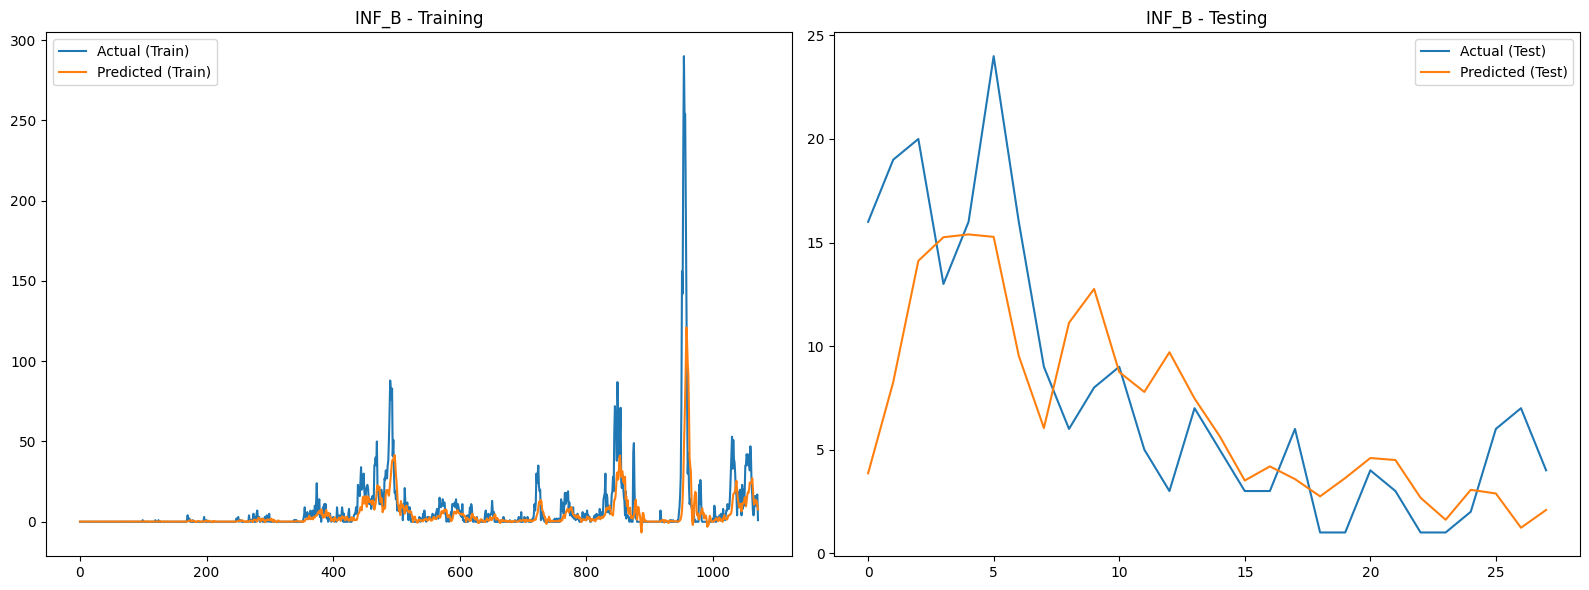

Epoch 20/50, Loss: 73.347
Epoch 40/50, Loss: 46.728

--- INF_B ---
Train RMSE: 6.63, MAE: 2.93, MAPE: 2089867746.74
Test  RMSE: 5.51, MAE: 4.03, MAPE: 73.13


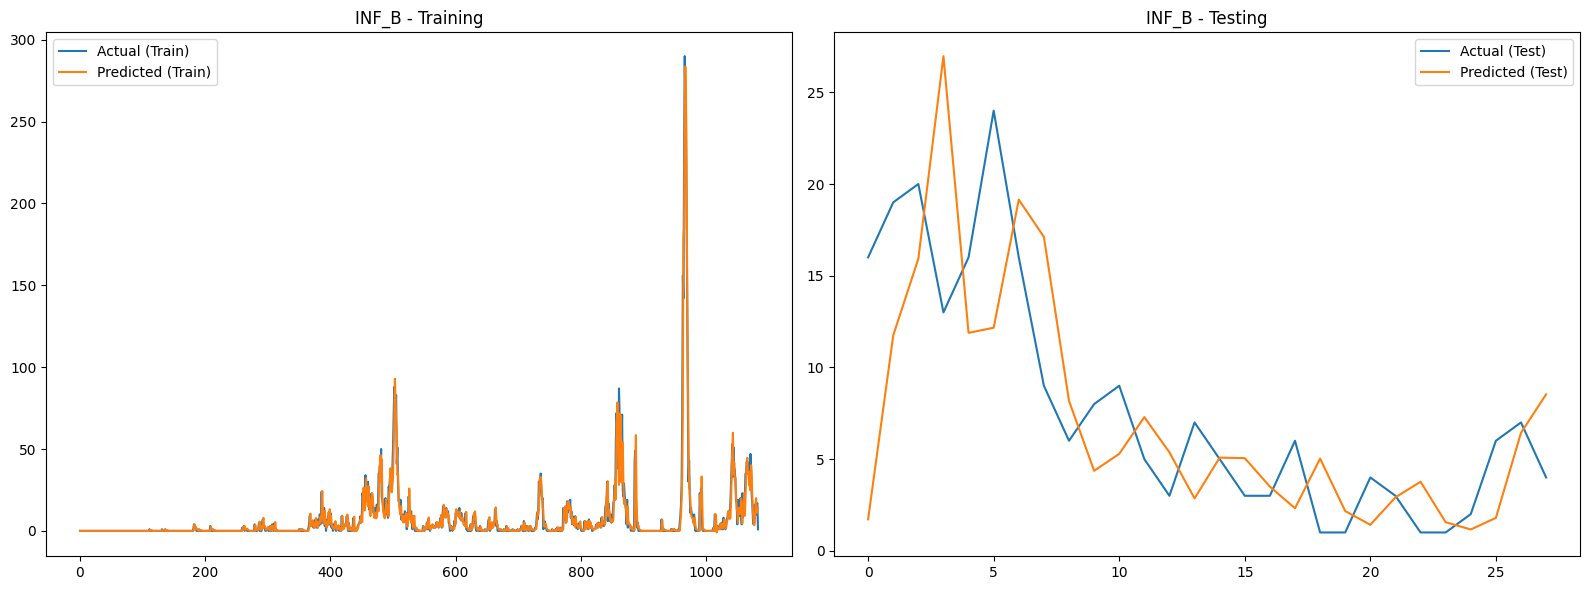

Epoch 20/50, Loss: 547.623
Epoch 40/50, Loss: 445.175

--- INF_B ---
Train RMSE: 20.08, MAE: 6.18, MAPE: 3610965899.80
Test  RMSE: 6.33, MAE: 4.29, MAPE: 57.47


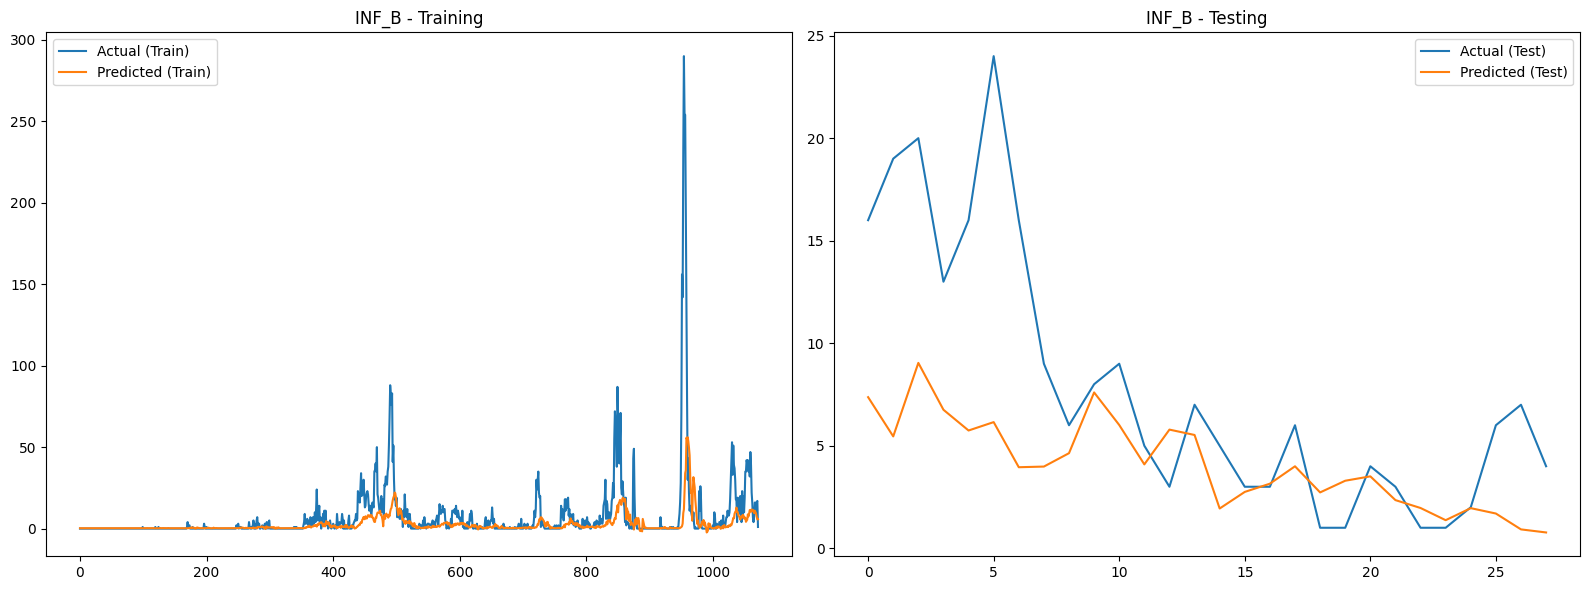

Epoch 20/120, Loss: 95.832
Epoch 40/120, Loss: 50.119
Epoch 60/120, Loss: 39.664
Epoch 80/120, Loss: 36.474
Epoch 100/120, Loss: 33.717
Epoch 120/120, Loss: 30.674

--- INF_B ---
Train RMSE: 5.53, MAE: 2.67, MAPE: 3435710268.22
Test  RMSE: 3.64, MAE: 2.80, MAPE: 71.78


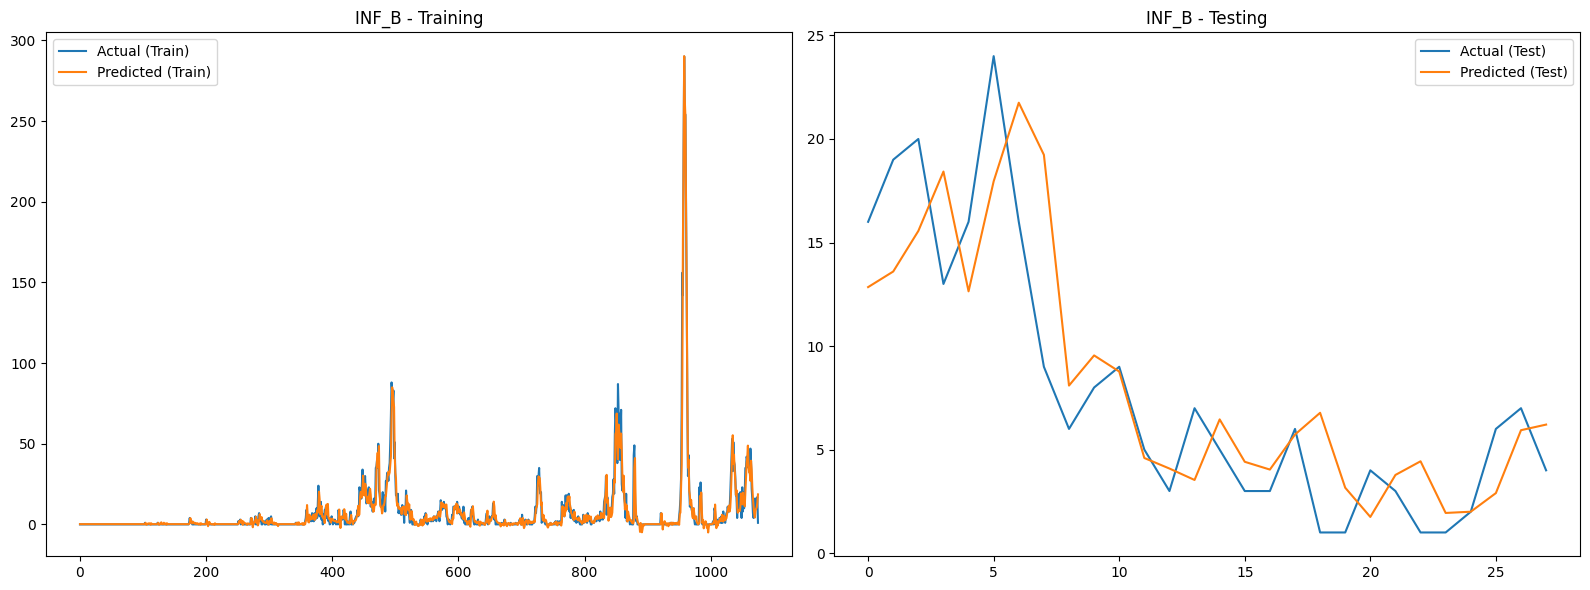

Epoch 20/120, Loss: 62.718
Epoch 40/120, Loss: 48.105
Epoch 60/120, Loss: 41.467
Epoch 80/120, Loss: 37.094
Epoch 100/120, Loss: 34.486
Epoch 120/120, Loss: 32.988

--- INF_B ---
Train RMSE: 5.74, MAE: 2.87, MAPE: 4560096004.50
Test  RMSE: 4.09, MAE: 3.24, MAPE: 84.25


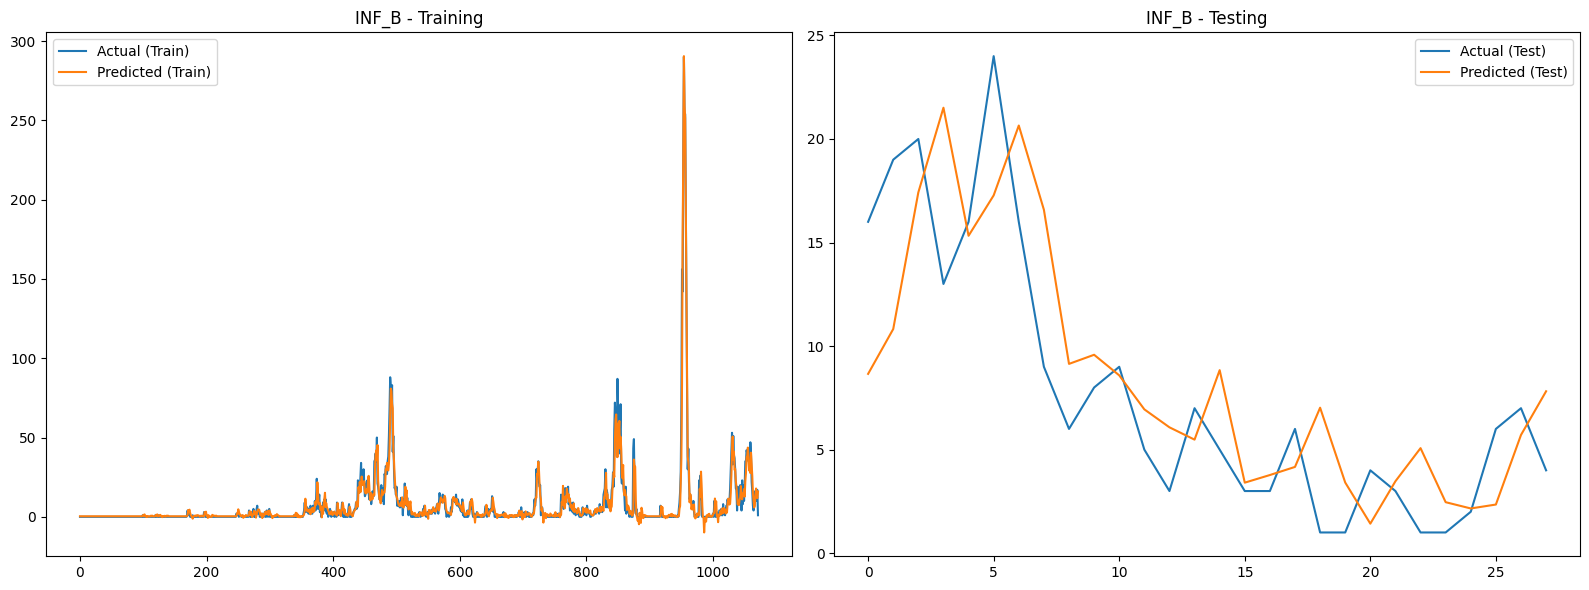

Epoch 20/80, Loss: 208.875
Epoch 40/80, Loss: 119.209
Epoch 60/80, Loss: 81.510
Epoch 80/80, Loss: 63.340

--- INF_B ---
Train RMSE: 7.92, MAE: 3.23, MAPE: 4302964399.18
Test  RMSE: 4.07, MAE: 3.19, MAPE: 77.95


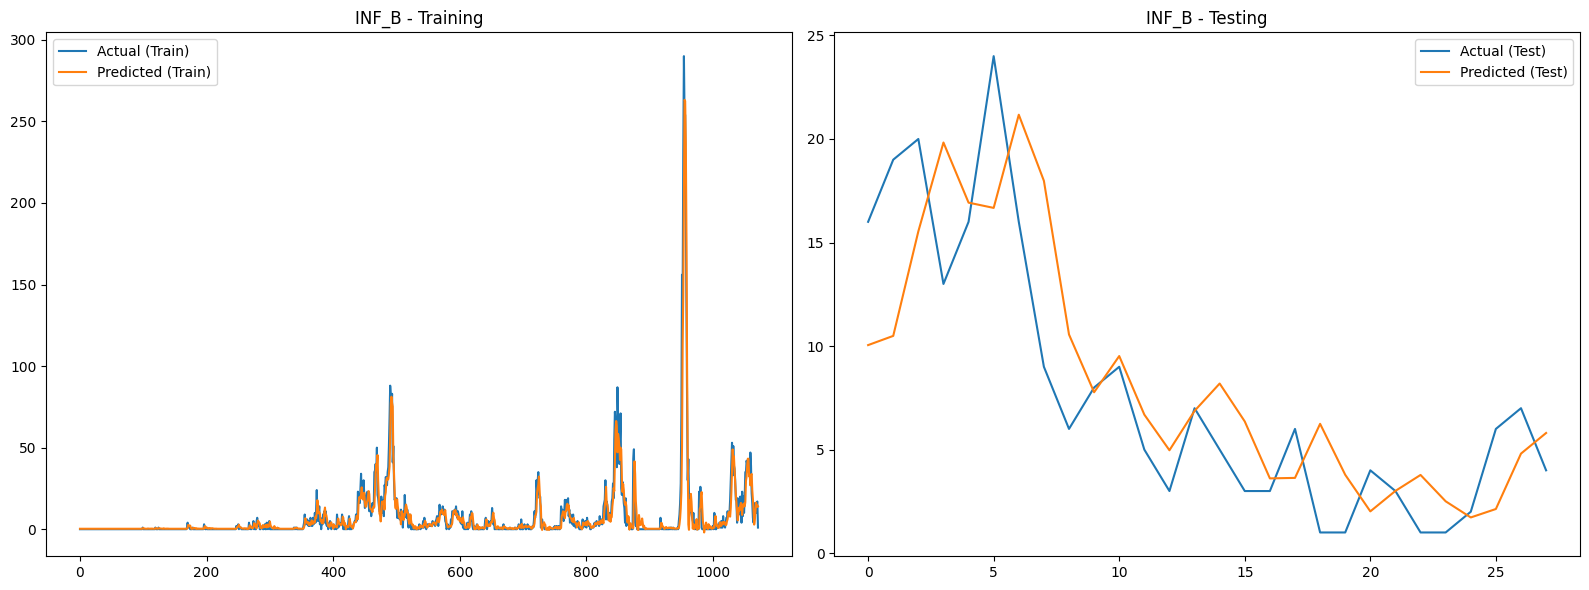

Epoch 20/80, Loss: 506.573
Epoch 40/80, Loss: 398.816
Epoch 60/80, Loss: 311.938
Epoch 80/80, Loss: 243.484

--- INF_B ---
Train RMSE: 15.51, MAE: 4.78, MAPE: 2281123479.59
Test  RMSE: 5.74, MAE: 3.89, MAPE: 45.15


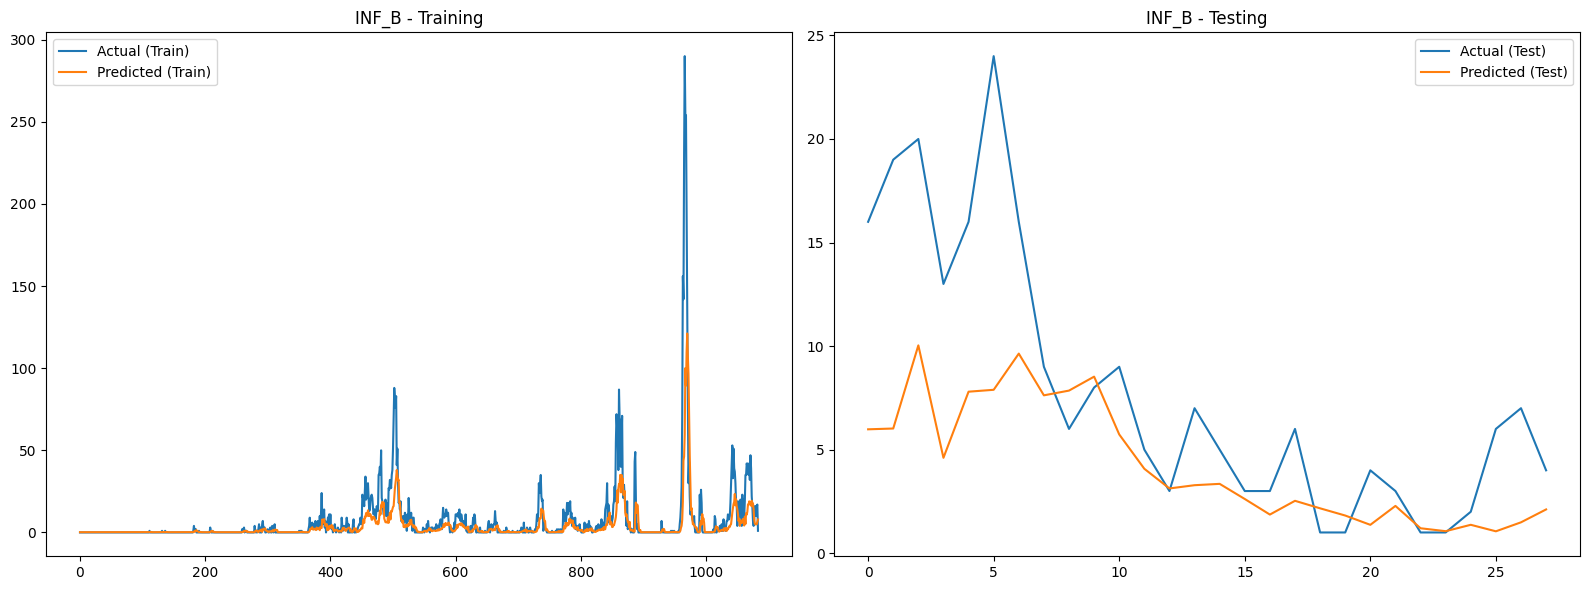

Epoch 20/80, Loss: 216.162
Epoch 40/80, Loss: 164.391
Epoch 60/80, Loss: 134.159
Epoch 80/80, Loss: 110.871

--- INF_B ---
Train RMSE: 10.48, MAE: 3.53, MAPE: 2474533593.80
Test  RMSE: 4.29, MAE: 3.08, MAPE: 52.97


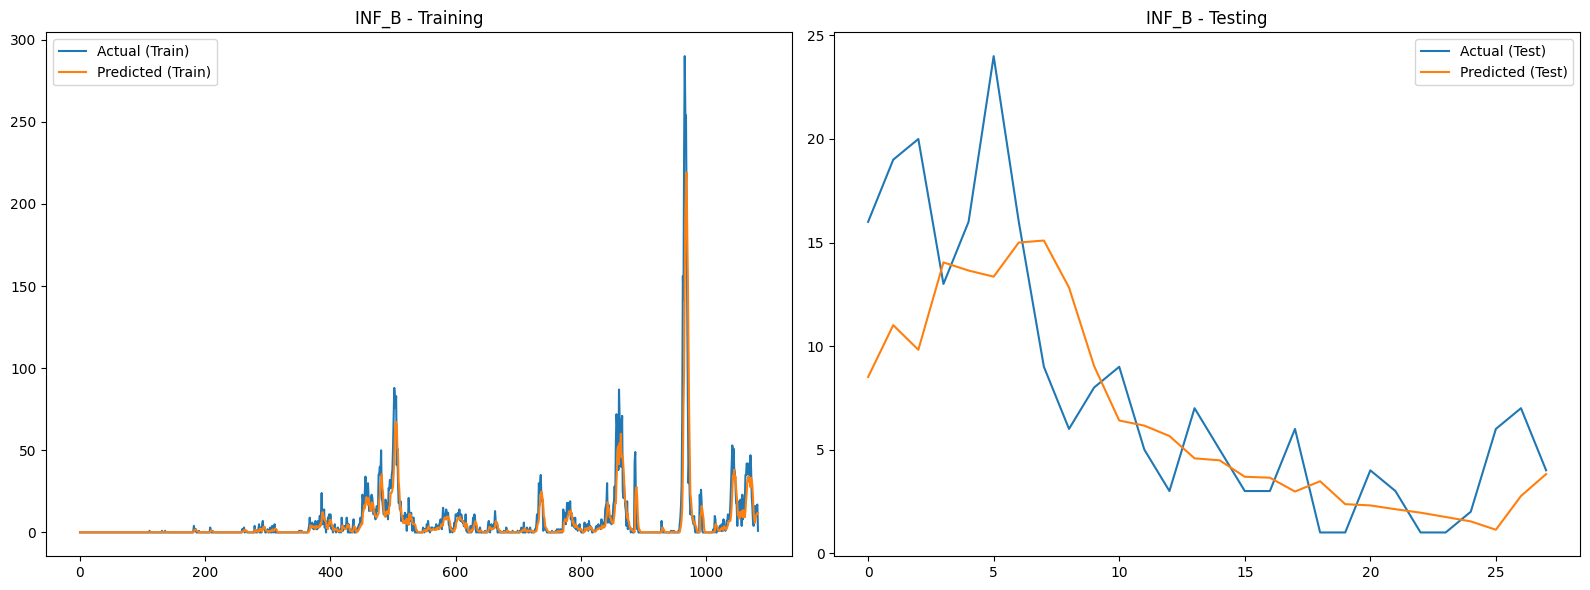

Epoch 20/50, Loss: 76.935
Epoch 40/50, Loss: 51.274

--- INF_B ---
Train RMSE: 6.78, MAE: 3.14, MAPE: 4150916087.18
Test  RMSE: 4.73, MAE: 3.44, MAPE: 63.75


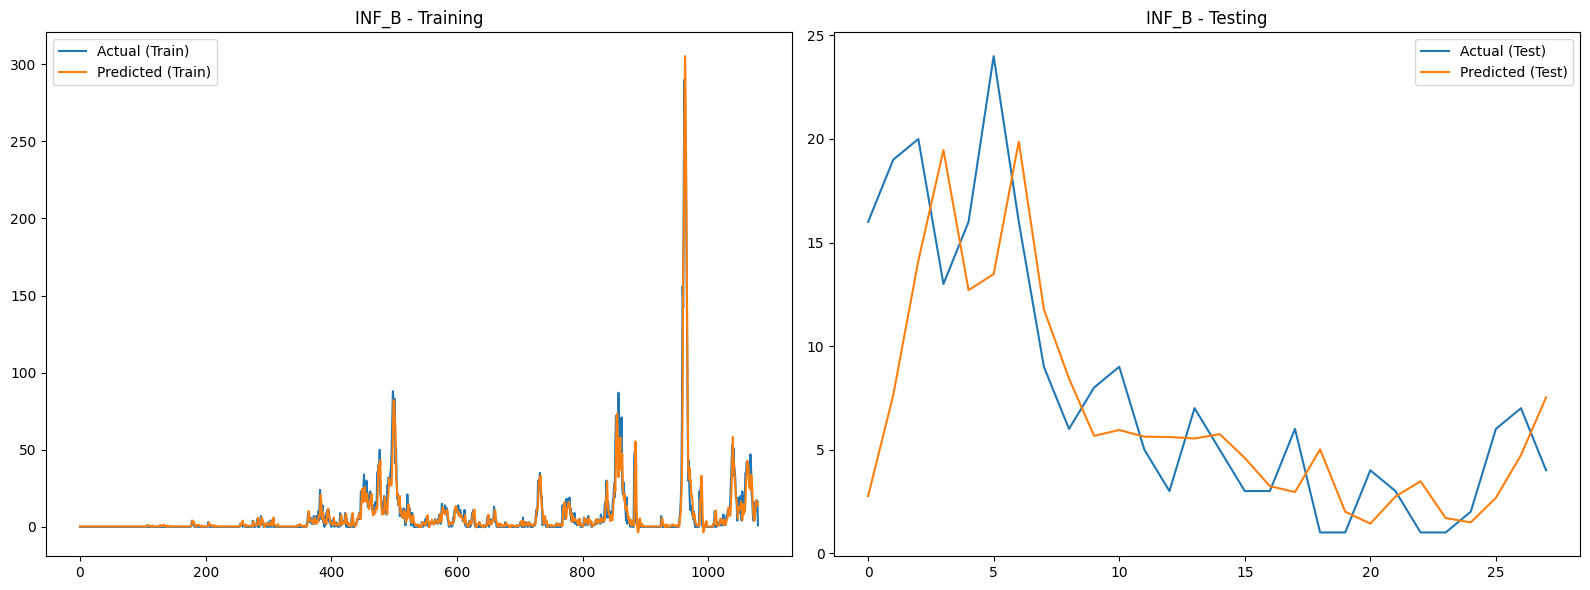

Epoch 20/120, Loss: 209.597
Epoch 40/120, Loss: 121.884
Epoch 60/120, Loss: 82.253
Epoch 80/120, Loss: 62.646
Epoch 100/120, Loss: 51.897
Epoch 120/120, Loss: 47.055

--- INF_B ---
Train RMSE: 6.85, MAE: 3.02, MAPE: 3951873874.71
Test  RMSE: 3.84, MAE: 3.14, MAPE: 76.62


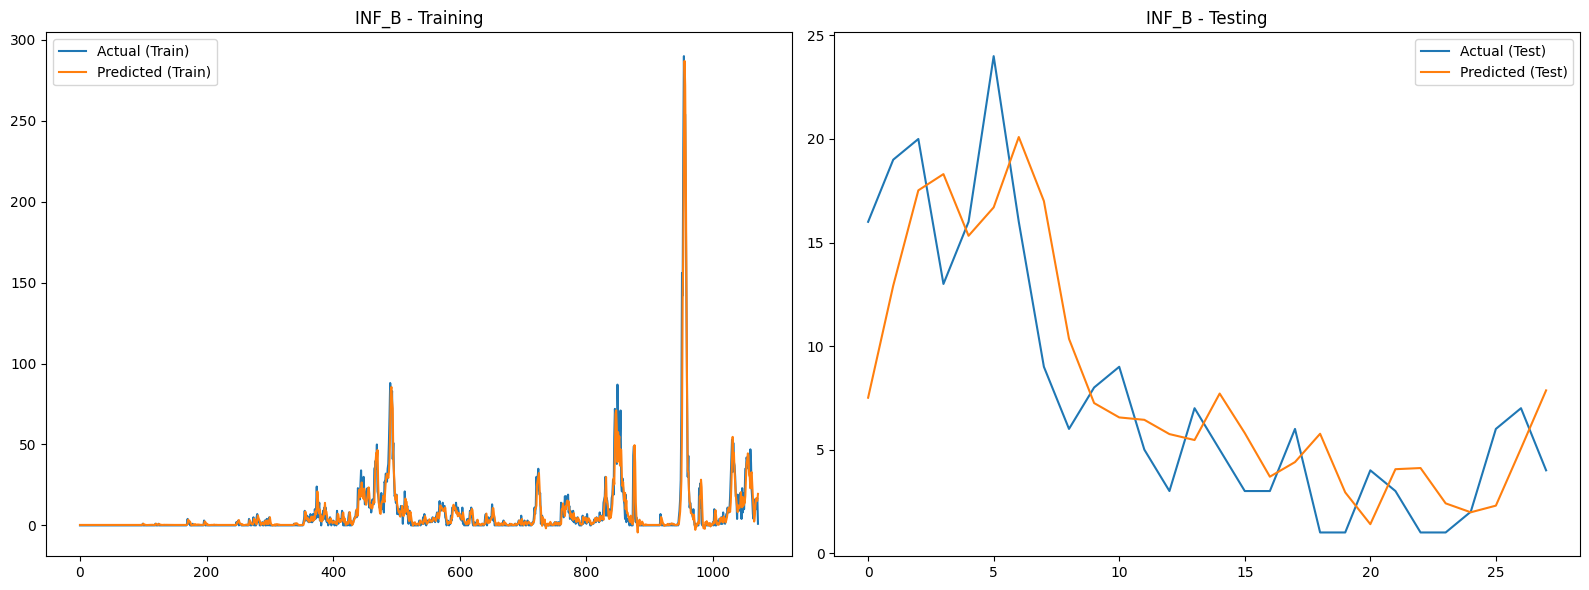

Epoch 20/50, Loss: 261.119
Epoch 40/50, Loss: 187.567

--- INF_B ---
Train RMSE: 12.69, MAE: 4.19, MAPE: 3603303324.96
Test  RMSE: 4.45, MAE: 3.32, MAPE: 62.22


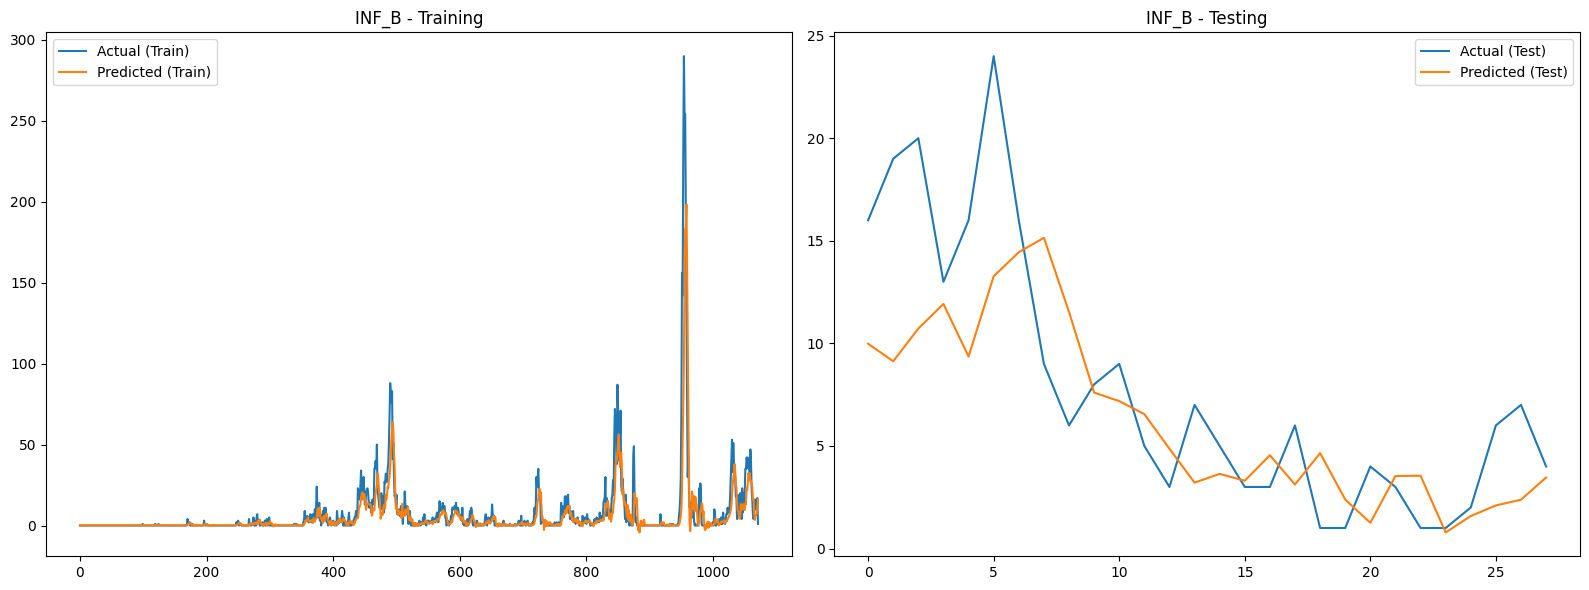

Epoch 20/120, Loss: 55.566
Epoch 40/120, Loss: 43.292
Epoch 60/120, Loss: 37.014
Epoch 80/120, Loss: 32.825
Epoch 100/120, Loss: 30.365
Epoch 120/120, Loss: 28.461

--- INF_B ---
Train RMSE: 5.33, MAE: 2.58, MAPE: 3381613790.09
Test  RMSE: 4.35, MAE: 3.30, MAPE: 72.19


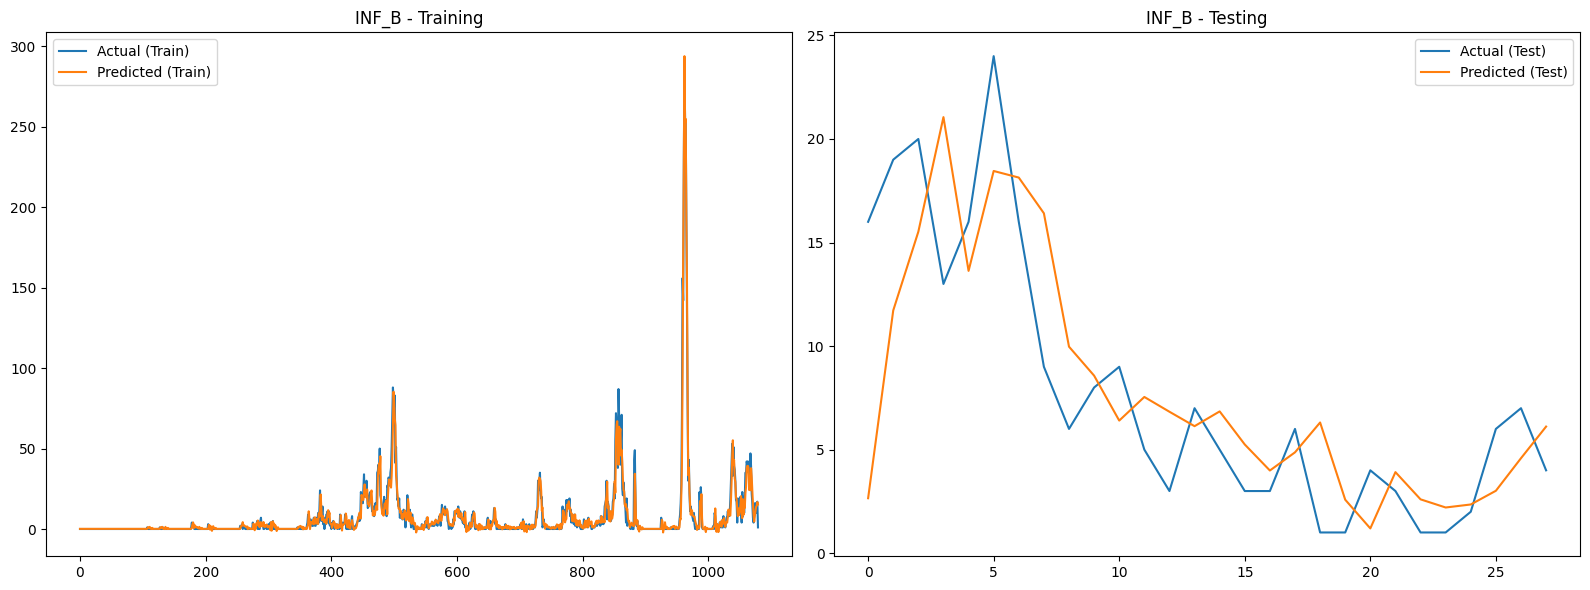

Epoch 20/50, Loss: 156.103
Epoch 40/50, Loss: 105.244

--- INF_B ---
Train RMSE: 9.12, MAE: 3.31, MAPE: 3397921963.53
Test  RMSE: 4.06, MAE: 3.13, MAPE: 61.92


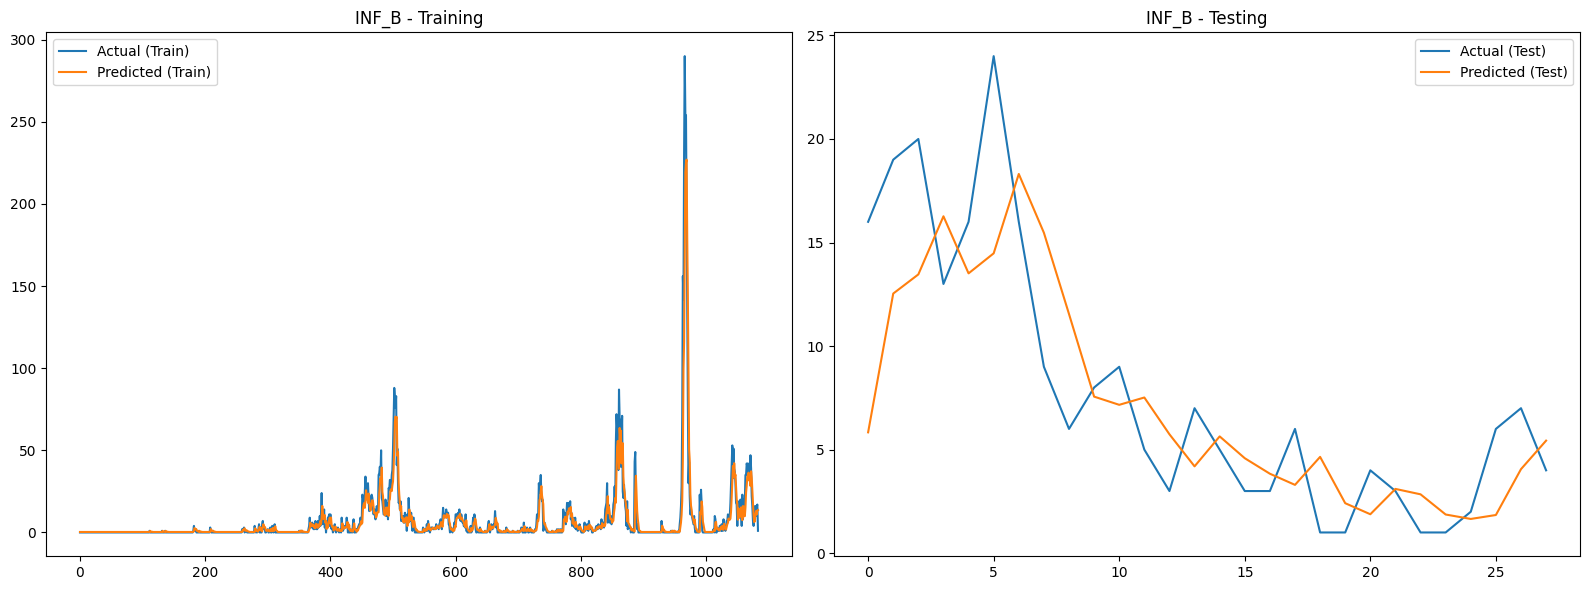

Epoch 20/120, Loss: 78.265
Epoch 40/120, Loss: 53.736
Epoch 60/120, Loss: 48.234
Epoch 80/120, Loss: 46.590
Epoch 100/120, Loss: 45.465
Epoch 120/120, Loss: 42.831

--- INF_B ---
Train RMSE: 6.53, MAE: 3.10, MAPE: 4575132528.05
Test  RMSE: 4.53, MAE: 3.25, MAPE: 66.88


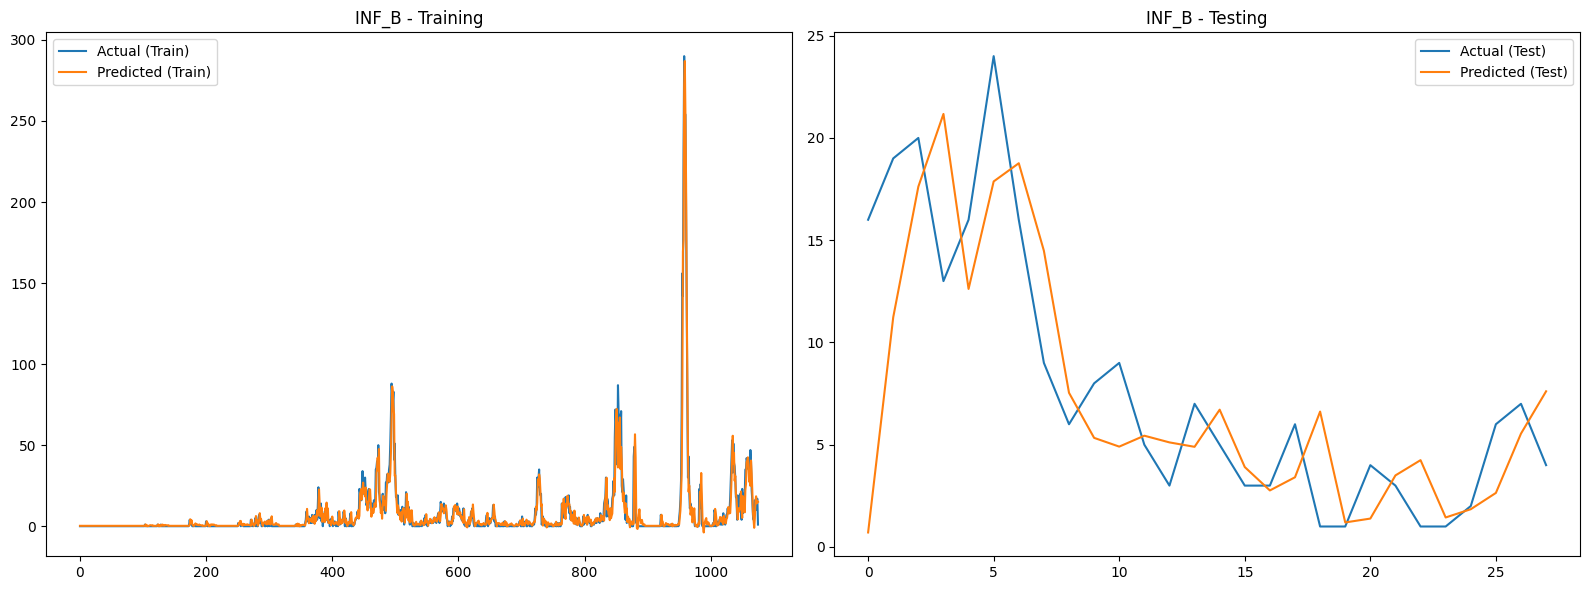

Epoch 20/50, Loss: 391.583
Epoch 40/50, Loss: 242.060

--- INF_B ---
Train RMSE: 13.79, MAE: 4.34, MAPE: 2323562857.07
Test  RMSE: 5.75, MAE: 3.94, MAPE: 51.27


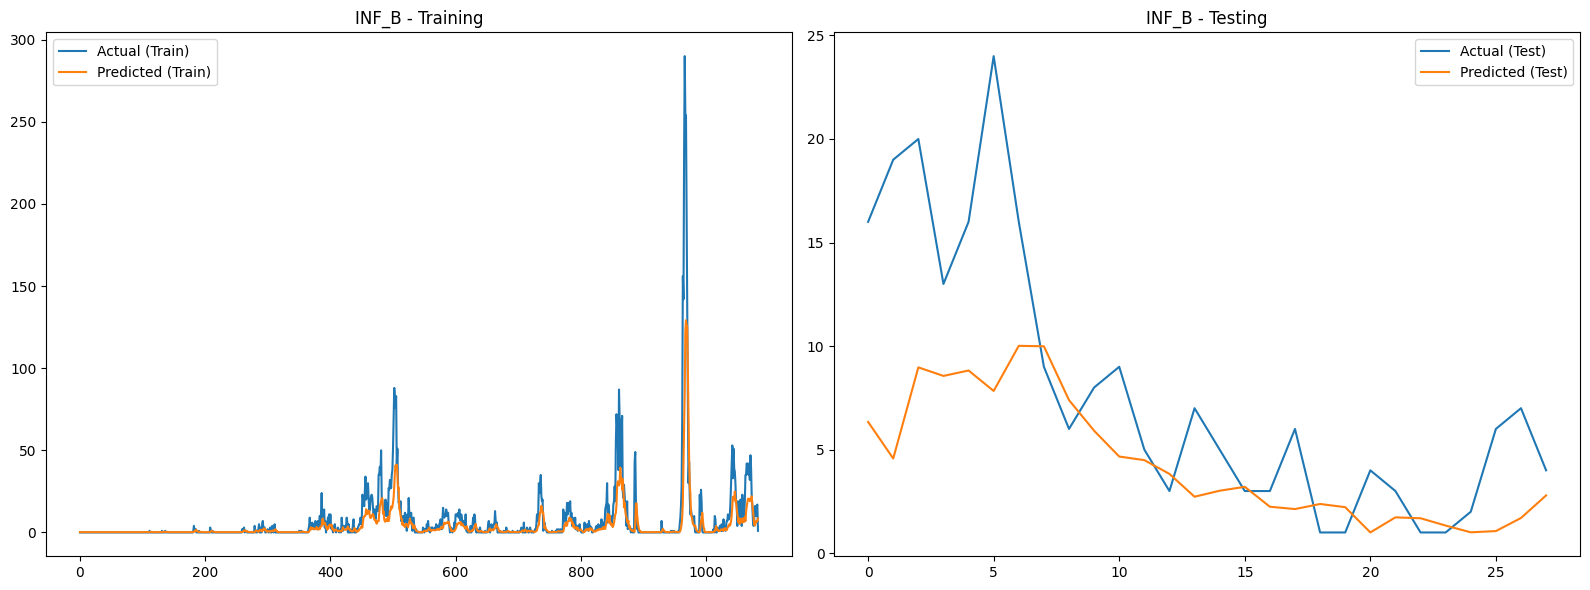

Epoch 20/80, Loss: 84.041
Epoch 40/80, Loss: 55.156
Epoch 60/80, Loss: 46.676
Epoch 80/80, Loss: 42.868

--- INF_B ---
Train RMSE: 6.54, MAE: 3.24, MAPE: 6317449288.48
Test  RMSE: 4.40, MAE: 3.49, MAPE: 81.62


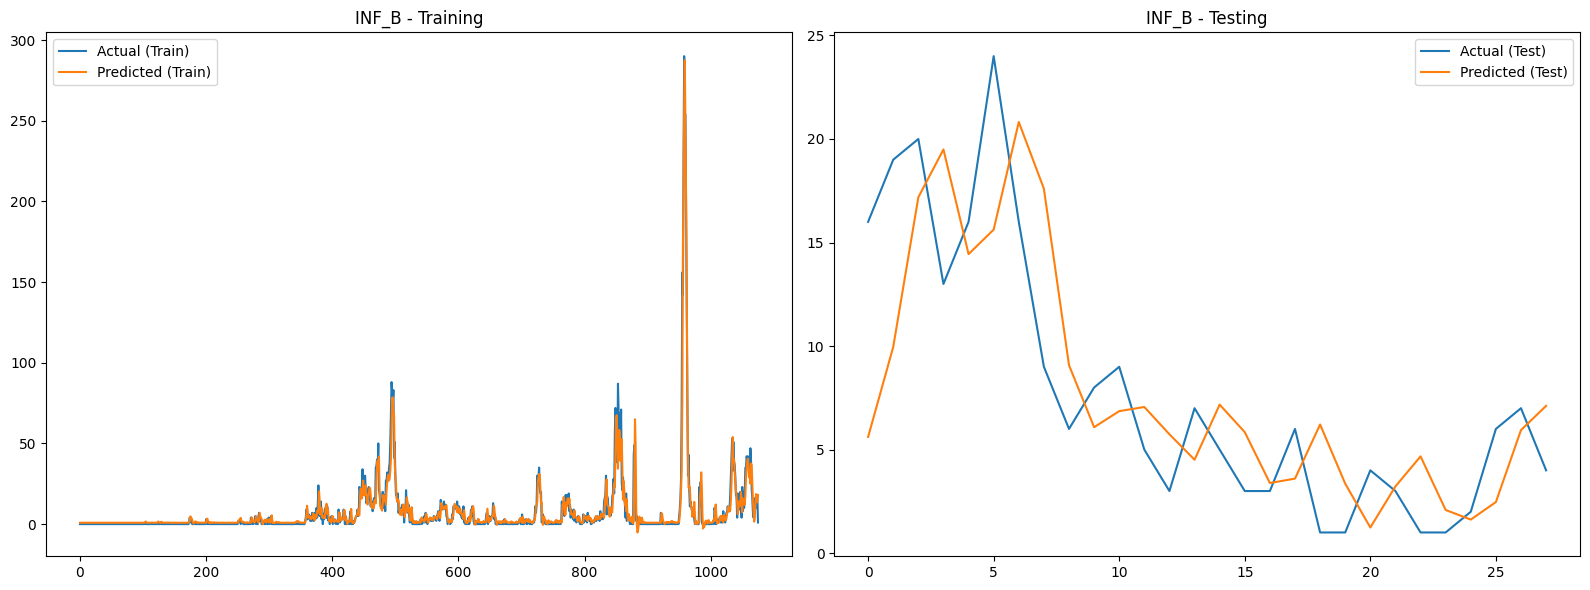

Epoch 20/80, Loss: 195.992
Epoch 40/80, Loss: 142.095
Epoch 60/80, Loss: 116.902
Epoch 80/80, Loss: 97.552

--- INF_B ---
Train RMSE: 9.83, MAE: 3.36, MAPE: 2453301907.55
Test  RMSE: 4.73, MAE: 3.51, MAPE: 64.47


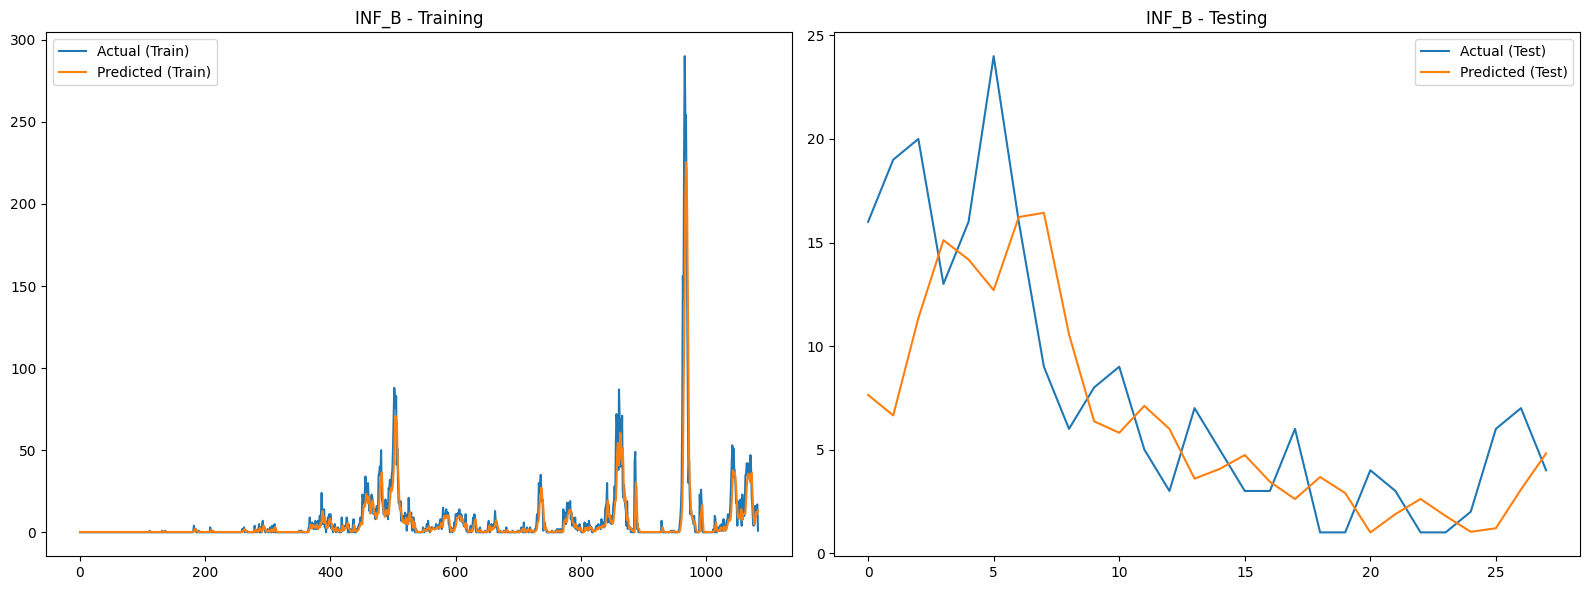

Epoch 20/120, Loss: 463.218
Epoch 40/120, Loss: 381.986
Epoch 60/120, Loss: 324.892
Epoch 80/120, Loss: 281.523
Epoch 100/120, Loss: 243.011
Epoch 120/120, Loss: 204.722

--- INF_B ---
Train RMSE: 14.25, MAE: 4.33, MAPE: 3084351452.54
Test  RMSE: 4.75, MAE: 3.42, MAPE: 51.18


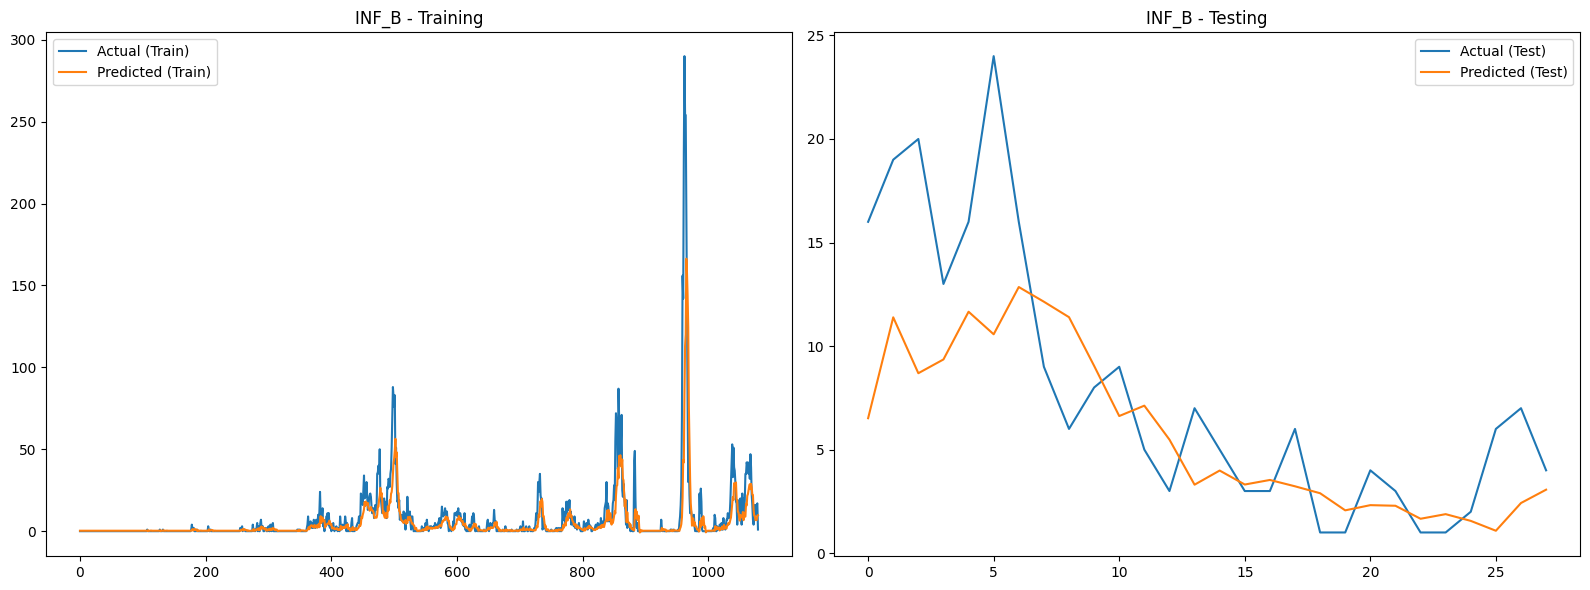

Best hyperparameters found: {'seq_length': 12, 'hidden_size': 64, 'lr': 0.01, 'epochs': 120}
Best test RMSE: 3.641804538759831


In [24]:
import random

# Define search space
seq_lengths = [4, 8, 12, 16]
hidden_sizes = [16, 32, 64, 128]
learning_rates = [0.01, 0.001, 0.0005]
epochs_list = [50, 80, 120]

best_score = float('inf')
best_params = None

for i in range(20):  # Try 20 random combinations
    params = {
        'seq_length': random.choice(seq_lengths),
        'hidden_size': random.choice(hidden_sizes),
        'lr': random.choice(learning_rates),
        'epochs': random.choice(epochs_list)
    }
    # Train and evaluate your AR-NET model here using these params
    # For demonstration, assume run_ar_net_forecast returns test RMSE
    metrics = run_ar_net_forecast('INF_B', **params)
    score = metrics['test']['rmse']
    if score < best_score:
        best_score = score
        best_params = params

print("Best hyperparameters found:", best_params)
print("Best test RMSE:", best_score)


## Best Parameters for INF_A

Epoch 20/50, Loss: 2308.186
Epoch 40/50, Loss: 1525.244

--- INF_A ---
Train RMSE: 37.61, MAE: 12.85, MAPE: 6108526672.94
Test  RMSE: 16.76, MAE: 11.45, MAPE: 37.00


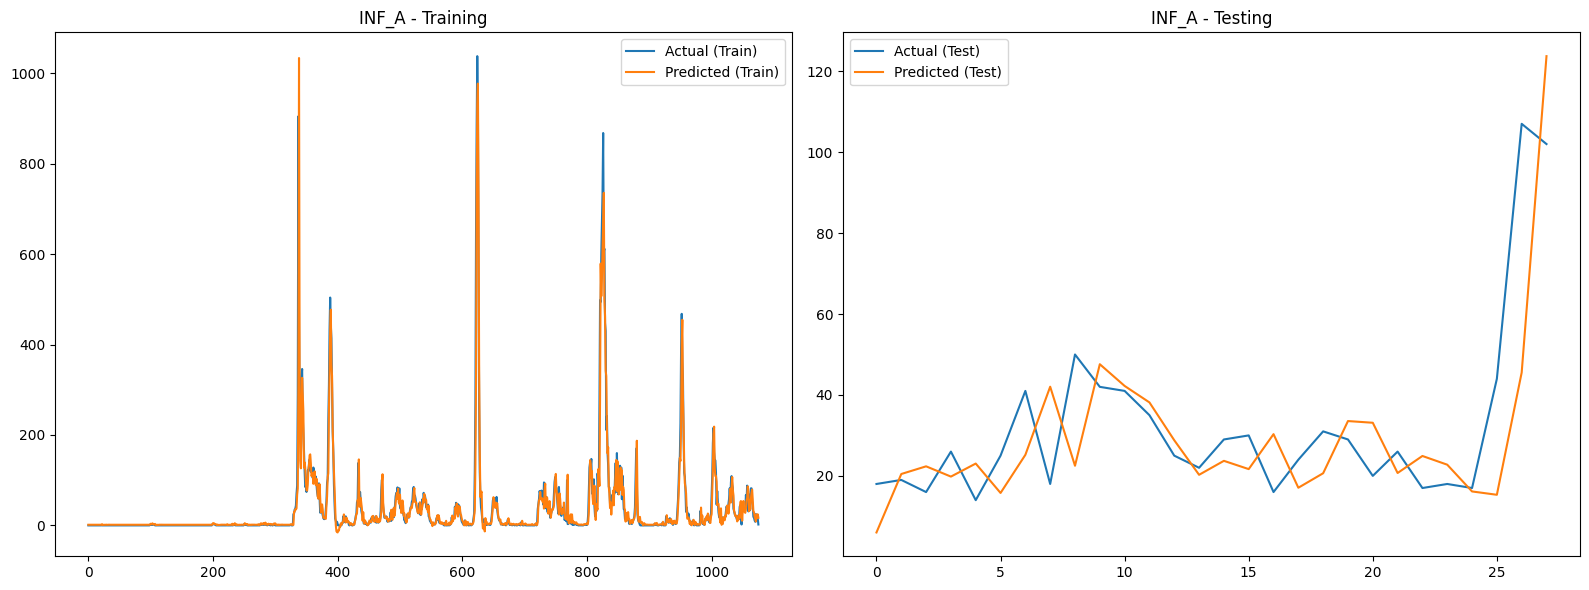

In [ ]:
# ---- Helper Functions ----
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return rmse, mae, mape

# ---- AR-NET Model ----
class ARNet(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
# ---- Main Function ----
def run_ar_net_forecast(target_col, seq_length=12, hidden_size=64, epochs=50, lr=0.01):
    # 1. Load Data
    df = pd.read_csv('cleaned_data.csv', parse_dates=['DATE'])
    df = df.sort_values('DATE')
    df = df[['DATE', target_col]].dropna()
    df[target_col] = df[target_col].astype(float)

    # 2. Train/Test Split
    train_df = df[df['DATE'] < '2024-01-01']
    test_df = df[df['DATE'] >= '2024-01-01']
    train_vals = train_df[target_col].values
    test_vals = test_df[target_col].values

    # 3. Sequence Creation
    X_train, y_train = create_sequences(train_vals, seq_length)
    X_test, y_test = create_sequences(np.concatenate([train_vals[-seq_length:], test_vals]), seq_length)

    # 4. Torch Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # 5. Model Init
    model = ARNet(seq_length, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 6. Training Loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.3f}')

    # 7. Predictions
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_t).numpy().flatten()
        test_pred = model(X_test_t).numpy().flatten()

    # 8. Evaluation
    train_rmse, train_mae, train_mape = evaluate(y_train, train_pred)
    test_rmse, test_mae, test_mape = evaluate(y_test, test_pred)

    print(f"\n--- {target_col} ---")
    print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}")
    print(f"Test  RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}")

    # 9. Plotting
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(y_train, label='Actual (Train)')
    plt.plot(train_pred, label='Predicted (Train)')
    plt.title(f'{target_col} - Training')
    plt.legend()





    plt.subplot(1,2,2)
    plt.plot(y_test, label='Actual (Test)')
    plt.plot(test_pred, label='Predicted (Test)')
    plt.title(f'{target_col} - Testing')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'train': {'rmse': train_rmse, 'mae': train_mae, 'mape': train_mape},
        'test': {'rmse': test_rmse, 'mae': test_mae, 'mape': test_mape}
    }

# ---- Run for Both Targets ----
metrics_a = run_ar_net_forecast('INF_A')


#### Best hyperparameters found: {'seq_length': 16, 'hidden_size': 64, 'lr': 0.01, 'epochs': 120}

Epoch 20/120, Loss: 63.673
Epoch 40/120, Loss: 43.260
Epoch 60/120, Loss: 38.002
Epoch 80/120, Loss: 34.765
Epoch 100/120, Loss: 32.568
Epoch 120/120, Loss: 30.850

--- INF_B ---
Train RMSE: 5.55, MAE: 2.67, MAPE: 3435477782.61
Test  RMSE: 3.57, MAE: 2.87, MAPE: 71.06


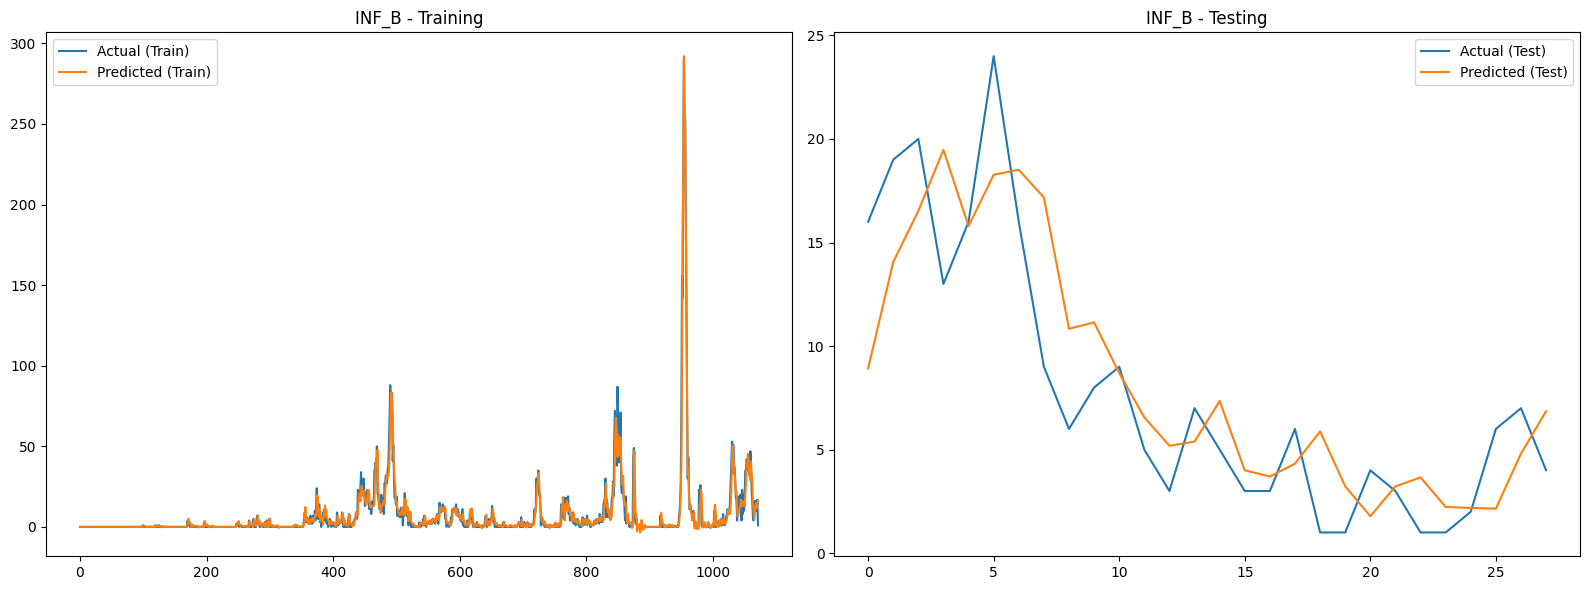

In [28]:
# ---- Helper Functions ----
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    return rmse, mae, mape

# ---- AR-NET Model ----
class ARNet(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
# ---- Main Function ----
def run_ar_net_forecast(target_col, seq_length=16, hidden_size=64, epochs=120, lr=0.01):
    # 1. Load Data
    df = pd.read_csv('cleaned_data.csv', parse_dates=['DATE'])
    df = df.sort_values('DATE')
    df = df[['DATE', target_col]].dropna()
    df[target_col] = df[target_col].astype(float)

    # 2. Train/Test Split
    train_df = df[df['DATE'] < '2024-01-01']
    test_df = df[df['DATE'] >= '2024-01-01']
    train_vals = train_df[target_col].values
    test_vals = test_df[target_col].values

    # 3. Sequence Creation
    X_train, y_train = create_sequences(train_vals, seq_length)
    X_test, y_test = create_sequences(np.concatenate([train_vals[-seq_length:], test_vals]), seq_length)

    # 4. Torch Tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # 5. Model Init
    model = ARNet(seq_length, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 6. Training Loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.3f}')

    # 7. Predictions
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train_t).numpy().flatten()
        test_pred = model(X_test_t).numpy().flatten()

    # 8. Evaluation
    train_rmse, train_mae, train_mape = evaluate(y_train, train_pred)
    test_rmse, test_mae, test_mape = evaluate(y_test, test_pred)

    print(f"\n--- {target_col} ---")
    print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}")
    print(f"Test  RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}")

    # 9. Plotting
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(y_train, label='Actual (Train)')
    plt.plot(train_pred, label='Predicted (Train)')
    plt.title(f'{target_col} - Training')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(y_test, label='Actual (Test)')
    plt.plot(test_pred, label='Predicted (Test)')
    plt.title(f'{target_col} - Testing')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'train': {'rmse': train_rmse, 'mae': train_mae, 'mape': train_mape},
        'test': {'rmse': test_rmse, 'mae': test_mae, 'mape': test_mape}
    }

# ---- Run for Both Targets ----
metrics_b = run_ar_net_forecast('INF_B')
